In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def display_images(img1, title1, img2, title2):
    plt.figure(figsize=(10, 5)) # 전체 그림의 크기를 설정
    
    # 첫 번째 이미지 표시
    plt.subplot(1, 2, 1) # 1행 2열 중 첫 번째 칸
    plt.imshow(img1, cmap='gray') # img1을 회색 맵으로 표시
    plt.title(title1) # 첫 번째 이미지의 제목 설정
    plt.axis('off') # 축(x, y 눈금)을 표시하지 않음

    # 두 번째 이미지 표시
    plt.subplot(1, 2, 2) # 1행 2열 중 두 번째 칸
    plt.imshow(img2, cmap='gray') # img2를 회색 맵으로 표시
    plt.title(title2) # 두 번째 이미지의 제목 설정
    plt.axis('off') # 축을 표시하지 않음
    
    plt.show() # 그림을 화면에 표시
# MOG2 배경 제거기 생성
# history: 배경 모델을 학습하기 위해 사용할 프레임의 개수 (클수록 안정적이지만 느림)
# varThreshold: 픽셀과 배경 모델 간의 마할라노비스 거리 제곱 임계값 (작을수록 더 많은 전경 감지)
# detectShadows: 그림자를 전경으로 감지할지 여부 (True/False)
fgbg = cv2.createBackgroundSubtractorMOG2(history=500, varThreshold=16, detectShadows=True)

# 시각화를 위한 리스트
original_frames = []
fg_masks = []
processed_frames = []
# 예시를 위해 5개의 가상 프레임을 생성합니다.
# 실제 비디오에서는 각 프레임을 읽어와서 처리합니다.
# 첫 30프레드는 배경 학습용, 이후 프레임은 객체 포함


In [10]:
nadf = pd.DataFrame(pd.read_csv('./thermal_data_none.csv'))
nadf.head()
frames_none = nadf.iloc[:,3:67]
# frames_none = frames_none*255/100
frames_none.shape

(4003, 64)

In [11]:
hudf = pd.DataFrame(pd.read_csv('./thermal_data_human_one.csv'))
hudf.head()
frames_hu = hudf.iloc[:,3:67]
# frames_hu = frames_hu*255/100
frames_hu.shape

(2077, 64)

In [17]:
frame_height, frame_width = 8, 8 # 이미지 크기

# --- 온도 데이터를 0-255 범위로 스케일링하는 함수 ---
def scale_temperature_to_uint8(temp_data, min_val, max_val):
    """
    온도 데이터를 0-255 범위의 uint8로 스케일링합니다.
    min_val: 전체 데이터에서 예상되는 최소 온도 값
    max_val: 전체 데이터에서 예상되는 최대 온도 값
    """
    scaled_data = (temp_data - min_val) / (max_val - min_val) * 255
    scaled_data = np.clip(scaled_data, 0, 255) # 0-255 범위를 벗어나지 않도록 클리핑
    return scaled_data.astype(np.uint8)

# 전체 온도 데이터의 예상 최소/최대값 설정 (데이터 특성에 맞게 조정 필요)
# 이 값을 기반으로 스케일링이 이루어집니다.
global_min_temp = min(frames_none.min().min(), frames_hu.min().min())
global_max_temp = max(frames_none.max().max(), frames_hu.max().max()) # 오타 수정
print(f"온도 데이터 전체 범위: {global_min_temp:.2f}°C ~ {global_max_temp:.2f}°C")
print("-" * 30)
 
# --- 1. 데이터프레임 할당 ---
frames_background = frames_none
frames_with_object = frames_hu

print(f"배경 프레임 수: {len(frames_background)}")
print(f"열원 포함 프레임 수: {len(frames_with_object)}")
print("-" * 30)

# 2. MOG2 배경 제거기 생성
fgbg = cv2.createBackgroundSubtractorMOG2(history=len(frames_background), varThreshold=16, detectShadows=False)

# --- 가우시안 필터 파라미터 ---
# ksize: 가우시안 커널 크기 (양의 홀수여야 함)
# sigmaX: X축 방향 표준 편차 (0이면 ksize에 따라 자동 계산)
gaussian_ksize = (3, 3) # 작은 커널로 미세 노이즈 제거
gaussian_sigmaX = 0    # 자동 계산

# 3. 배경 프레임으로 배경 모델 초기 학습
print("--- 배경 프레임으로 배경 모델 학습 시작 ---")
for i in range(len(frames_background.index)):
    temp_frame_2d = frames_background.iloc[i,:].values.reshape((frame_height, frame_width))
    scaled_frame = scale_temperature_to_uint8(temp_frame_2d, global_min_temp, global_max_temp)
    
    # 가우시안 필터 적용
    blurred_frame = cv2.GaussianBlur(scaled_frame, gaussian_ksize, gaussian_sigmaX)

    fgmask_dummy = fgbg.apply(blurred_frame) # 필터링된 프레임으로 학습
    
    if (i + 1) % 500 == 0:
        print(f"  {i + 1}/{len(frames_background)} 프레임 학습 완료...")
print("--- 배경 모델 학습 완료 ---")
print("-" * 30)

# 4. 객체가 있는 프레임을 넣어 전경 감지 및 추출
original_frames_results = [] # 스케일링 전 원본 (시각화용)
blurred_frames_results = [] # 가우시안 필터 적용 후 프레임
fg_masks_results = []
fg_only_frames_results = []

print("--- 열원 포함 프레임 처리 시작 ---")
for i in range(len(frames_with_object.index)):
    temp_frame_2d = frames_with_object.iloc[i,:].values.reshape((frame_height, frame_width))
    scaled_frame = scale_temperature_to_uint8(temp_frame_2d, global_min_temp, global_max_temp)
    
    # 가우시안 필터 적용
    blurred_frame = cv2.GaussianBlur(scaled_frame, gaussian_ksize, gaussian_sigmaX)

    fgmask = fgbg.apply(blurred_frame) # 필터링된 프레임으로 전경 감지
    
    # 전경 마스크를 사용하여 스케일링된 원본 프레임에서 열원만 추출 (필터링되지 않은 원본에 마스크 적용)
    # 또는 필터링된 프레임에 마스크를 적용할 수도 있습니다. 여기서는 필터링된 프레임에 적용합니다.
    fg_only = cv2.bitwise_and(blurred_frame, blurred_frame, mask=fgmask)

    original_frames_results.append(scaled_frame) 
    blurred_frames_results.append(blurred_frame) # 가우시안 적용된 프레임 추가
    fg_masks_results.append(fgmask)
    fg_only_frames_results.append(fg_only)

    if (i + 1) % 200 == 0:
        print(f"  {i + 1}/{len(frames_with_object)} 프레임 처리 완료...")
print("--- 열원 포함 프레임 처리 완료 ---")
print("-" * 30)

온도 데이터 전체 범위: 21.75°C ~ 30.00°C
------------------------------
배경 프레임 수: 4003
열원 포함 프레임 수: 2077
------------------------------
--- 배경 프레임으로 배경 모델 학습 시작 ---
  500/4003 프레임 학습 완료...
  1000/4003 프레임 학습 완료...
  1500/4003 프레임 학습 완료...
  2000/4003 프레임 학습 완료...
  2500/4003 프레임 학습 완료...
  3000/4003 프레임 학습 완료...
  3500/4003 프레임 학습 완료...
  4000/4003 프레임 학습 완료...
--- 배경 모델 학습 완료 ---
------------------------------
--- 열원 포함 프레임 처리 시작 ---
  200/2077 프레임 처리 완료...
  400/2077 프레임 처리 완료...
  600/2077 프레임 처리 완료...
  800/2077 프레임 처리 완료...
  1000/2077 프레임 처리 완료...
  1200/2077 프레임 처리 완료...
  1400/2077 프레임 처리 완료...
  1600/2077 프레임 처리 완료...
  1800/2077 프레임 처리 완료...
  2000/2077 프레임 처리 완료...
--- 열원 포함 프레임 처리 완료 ---
------------------------------


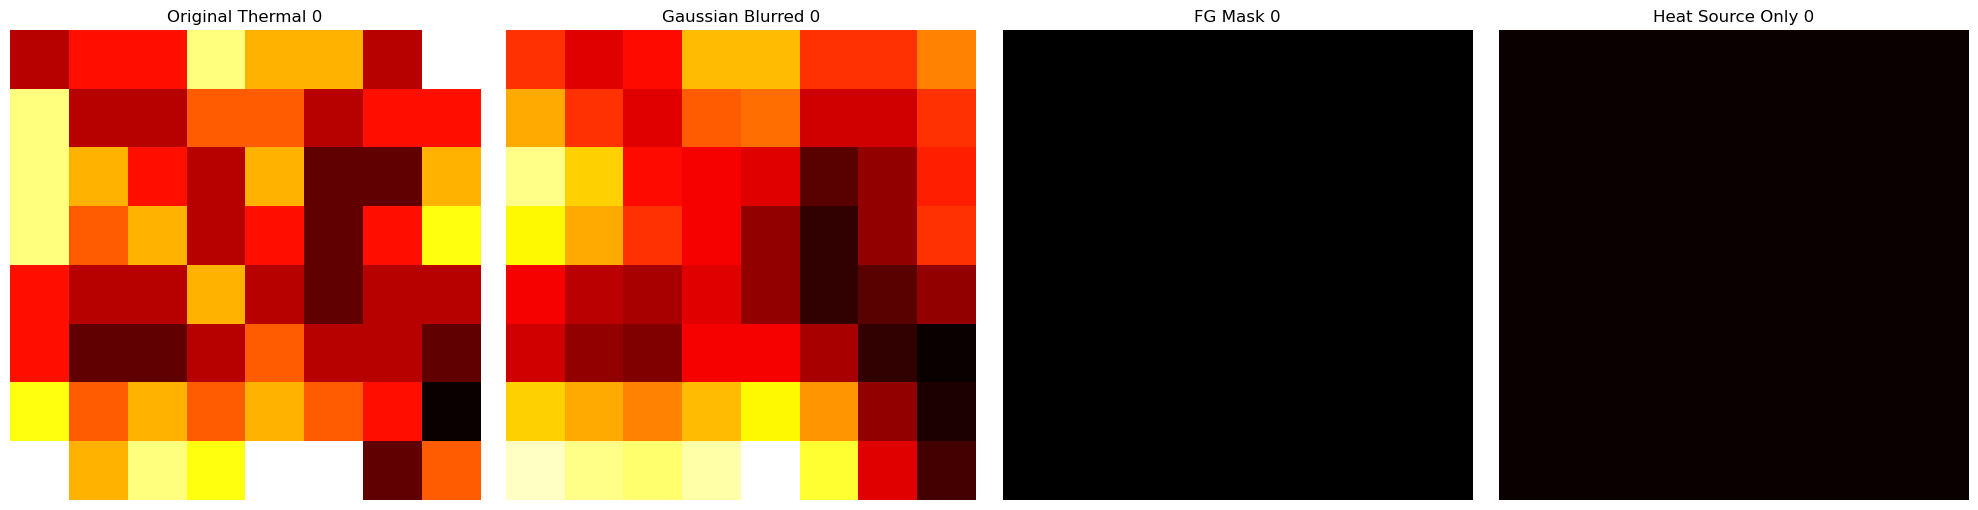

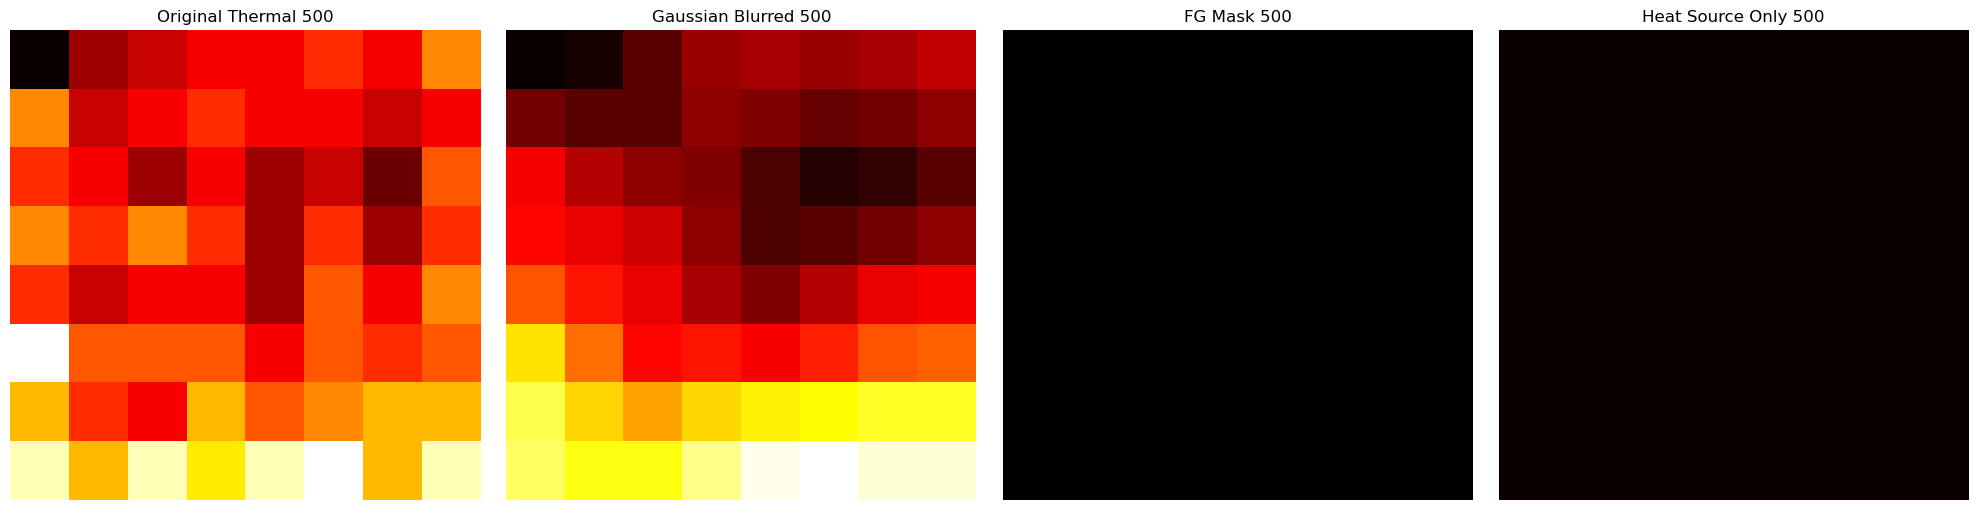

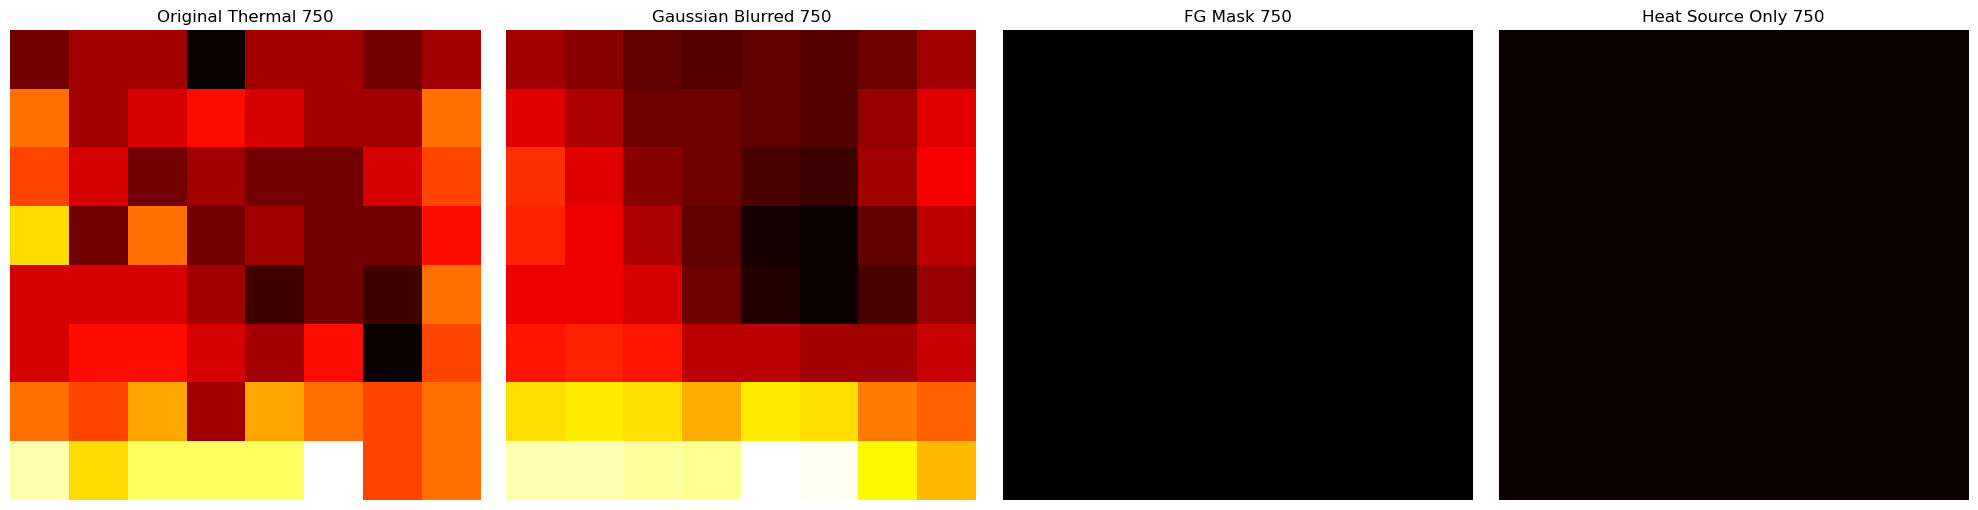

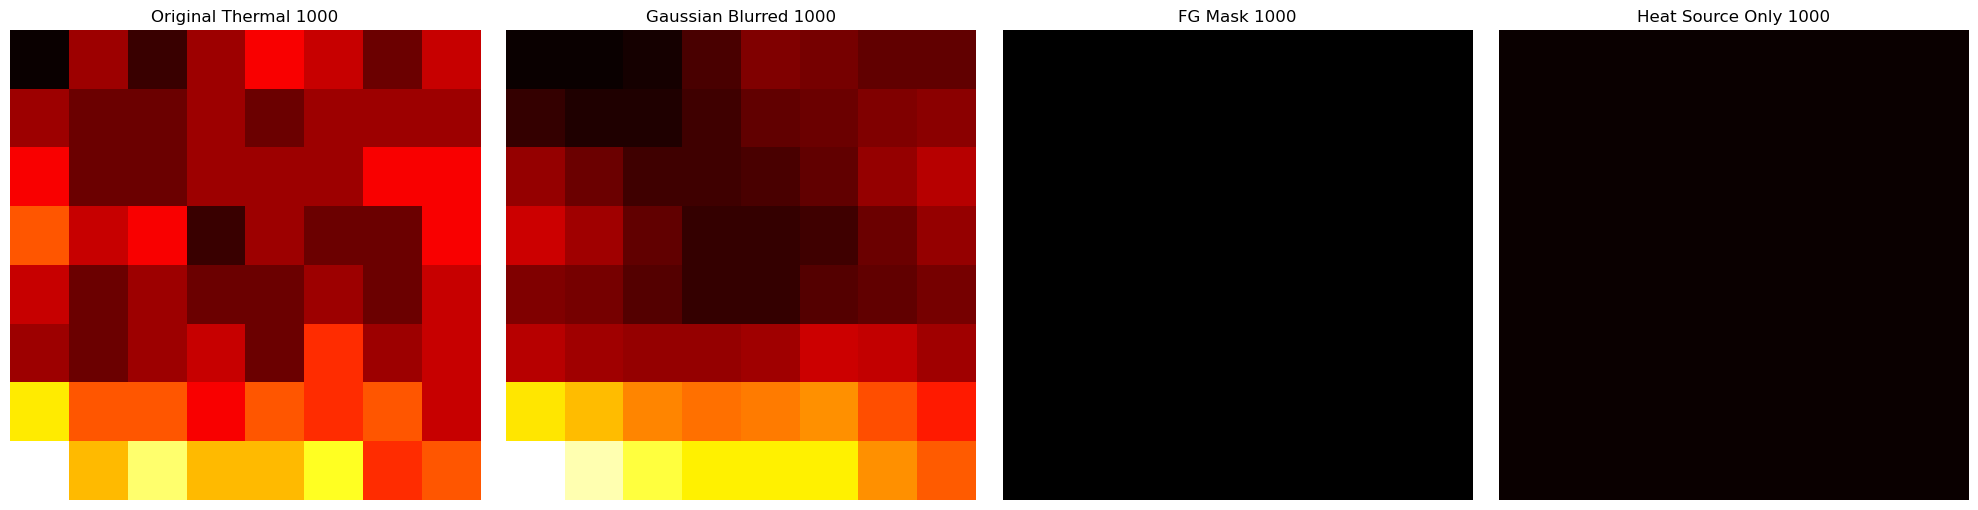

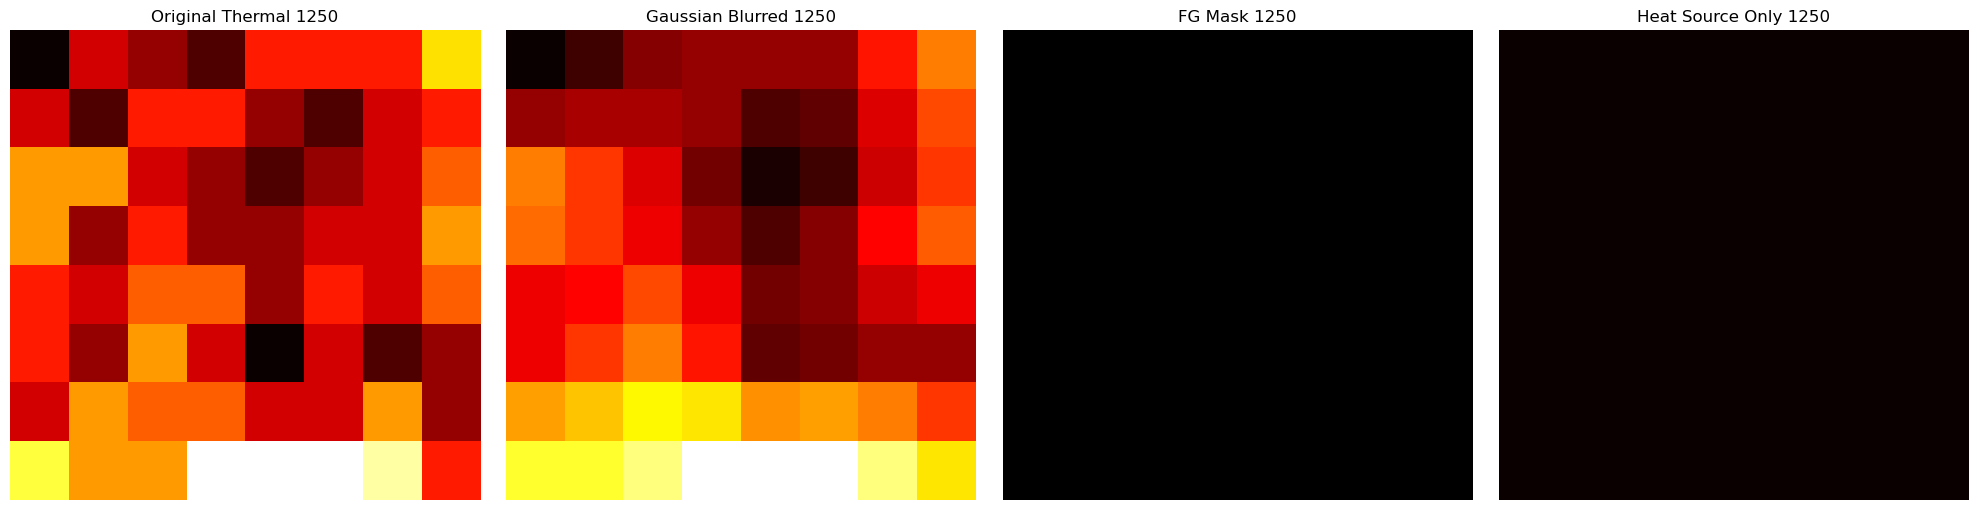

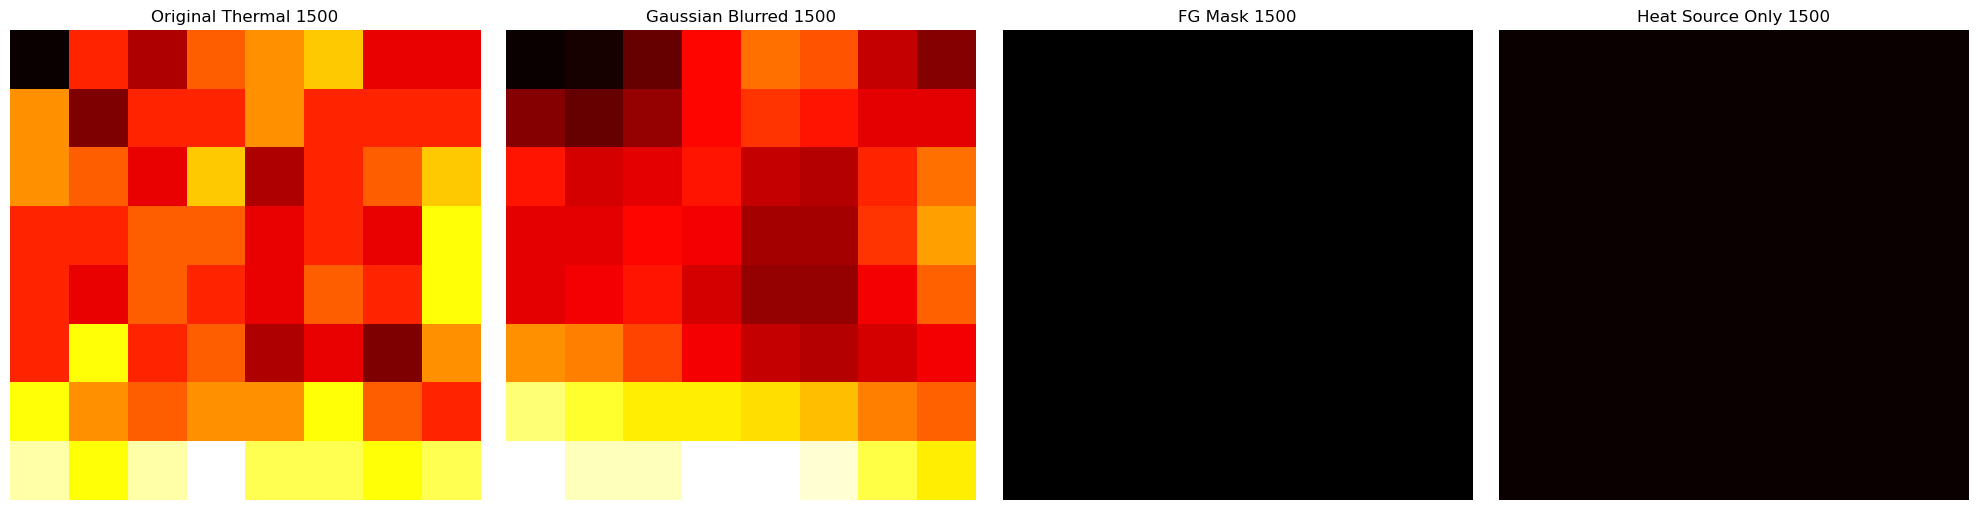

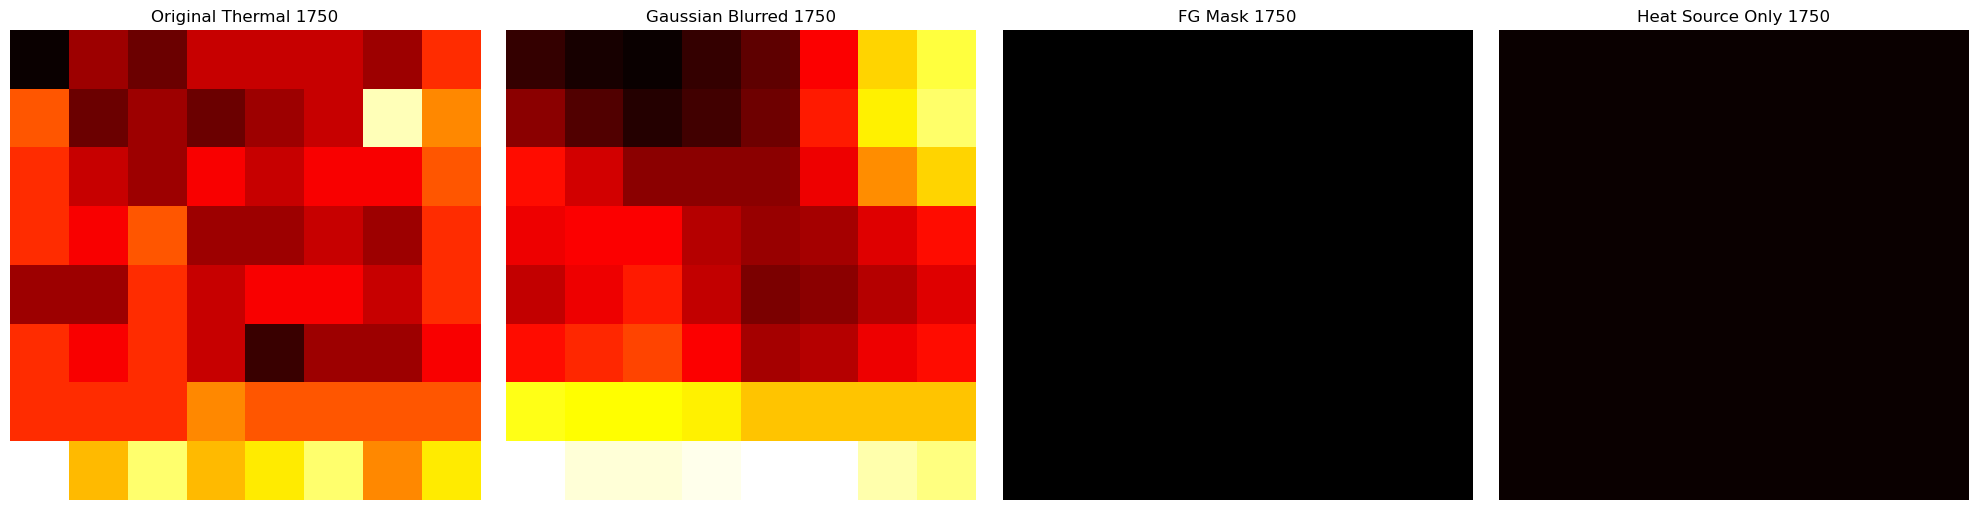


--- 마스크 후처리 결과 (열원 포함 프레임 100) ---


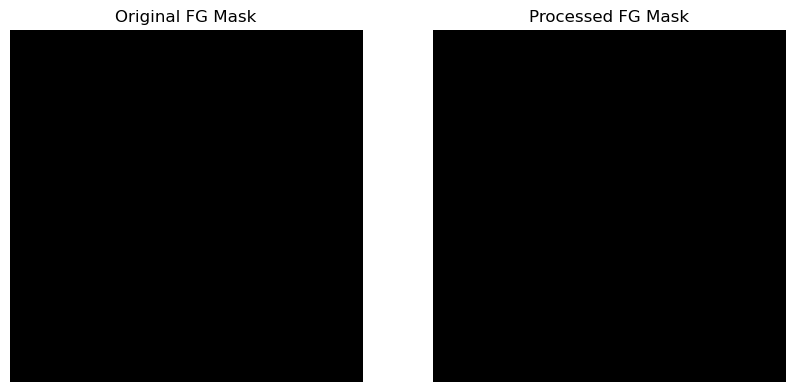

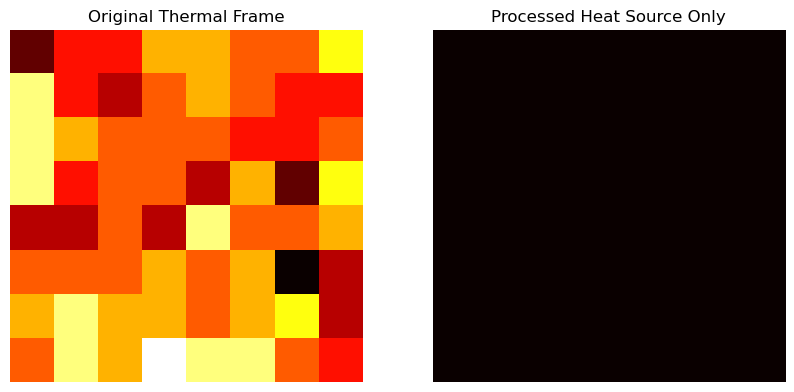

In [18]:
# 5. 결과 시각화
def display_images_temp(img1, title1, img2, title2, cmap_val='hot'):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img1, cmap=cmap_val) 
    plt.title(title1)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img2, cmap=cmap_val) 
    plt.title(title2)
    plt.axis('off')
    plt.show()

def display_full_pipeline(original_img, blurred_img, fg_mask, fg_only_img, idx):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5)) # 4개 서브플롯
    
    axes[0].imshow(original_img, cmap='hot')
    axes[0].set_title(f'Original Thermal {idx}')
    axes[0].axis('off')

    axes[1].imshow(blurred_img, cmap='hot')
    axes[1].set_title(f'Gaussian Blurred {idx}')
    axes[1].axis('off')

    axes[2].imshow(fg_mask, cmap='gray')
    axes[2].set_title(f'FG Mask {idx}')
    axes[2].axis('off')

    axes[3].imshow(fg_only_img, cmap='hot')
    axes[3].set_title(f'Heat Source Only {idx}')
    axes[3].axis('off')
    plt.tight_layout()
    plt.show()


# 시각화할 프레임 인덱스 선택 (요청하신 대로 확장)
display_idx = [
    0,                                      
    min(500, len(frames_with_object) - 1),  
    min(750, len(frames_with_object) - 1),  
    min(1000, len(frames_with_object) - 1), 
    min(1250, len(frames_with_object) - 1), 
    min(1500, len(frames_with_object) - 1), 
    min(1750, len(frames_with_object) - 1), 
]

# 각 인덱스에 대해 파이프라인 시각화
for idx in display_idx:
    display_full_pipeline(
        original_frames_results[idx],
        blurred_frames_results[idx],
        fg_masks_results[idx],
        fg_only_frames_results[idx],
        idx
    )

# 6. 마스크 후처리 (선택 사항)
post_process_idx = min(100, len(fg_masks_results) - 1) 
fgmask_example = fg_masks_results[post_process_idx]
original_frame_for_post = original_frames_results[post_process_idx] # 후처리에 사용할 원본 프레임

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

dilated_mask = cv2.dilate(fgmask_example, kernel, iterations=1)
eroded_mask = cv2.erode(dilated_mask, kernel, iterations=1)

# 후처리된 마스크를 필터링된 프레임에 적용하여 전경 추출
# 만약 마스크를 원본 스케일링된 프레임에 적용하고 싶다면 original_frame_for_post를 사용
fg_only_processed = cv2.bitwise_and(blurred_frames_results[post_process_idx], blurred_frames_results[post_process_idx], mask=eroded_mask)

print(f"\n--- 마스크 후처리 결과 (열원 포함 프레임 {post_process_idx}) ---")
display_images_temp(fgmask_example, 'Original FG Mask', eroded_mask, 'Processed FG Mask', cmap_val='gray')
display_images_temp(original_frame_for_post, 'Original Thermal Frame', fg_only_processed, 'Processed Heat Source Only', cmap_val='hot')

온도 데이터 전체 범위: 21.75°C ~ 30.00°C
------------------------------
배경 프레임 수: 4003
열원 포함 프레임 수: 2077
------------------------------
--- 배경 프레임으로 배경 모델 학습 시작 ---
  500/4003 프레임 학습 완료...
  1000/4003 프레임 학습 완료...
  1500/4003 프레임 학습 완료...
  2000/4003 프레임 학습 완료...
  2500/4003 프레임 학습 완료...
  3000/4003 프레임 학습 완료...
  3500/4003 프레임 학습 완료...
  4000/4003 프레임 학습 완료...
--- 배경 모델 학습 완료 ---
------------------------------
--- 열원 포함 프레임 처리 시작 ---
  200/2077 프레임 처리 완료...
  400/2077 프레임 처리 완료...
  600/2077 프레임 처리 완료...
  800/2077 프레임 처리 완료...
  1000/2077 프레임 처리 완료...
  1200/2077 프레임 처리 완료...
  1400/2077 프레임 처리 완료...
  1600/2077 프레임 처리 완료...
  1800/2077 프레임 처리 완료...
  2000/2077 프레임 처리 완료...
--- 열원 포함 프레임 처리 완료 ---
------------------------------


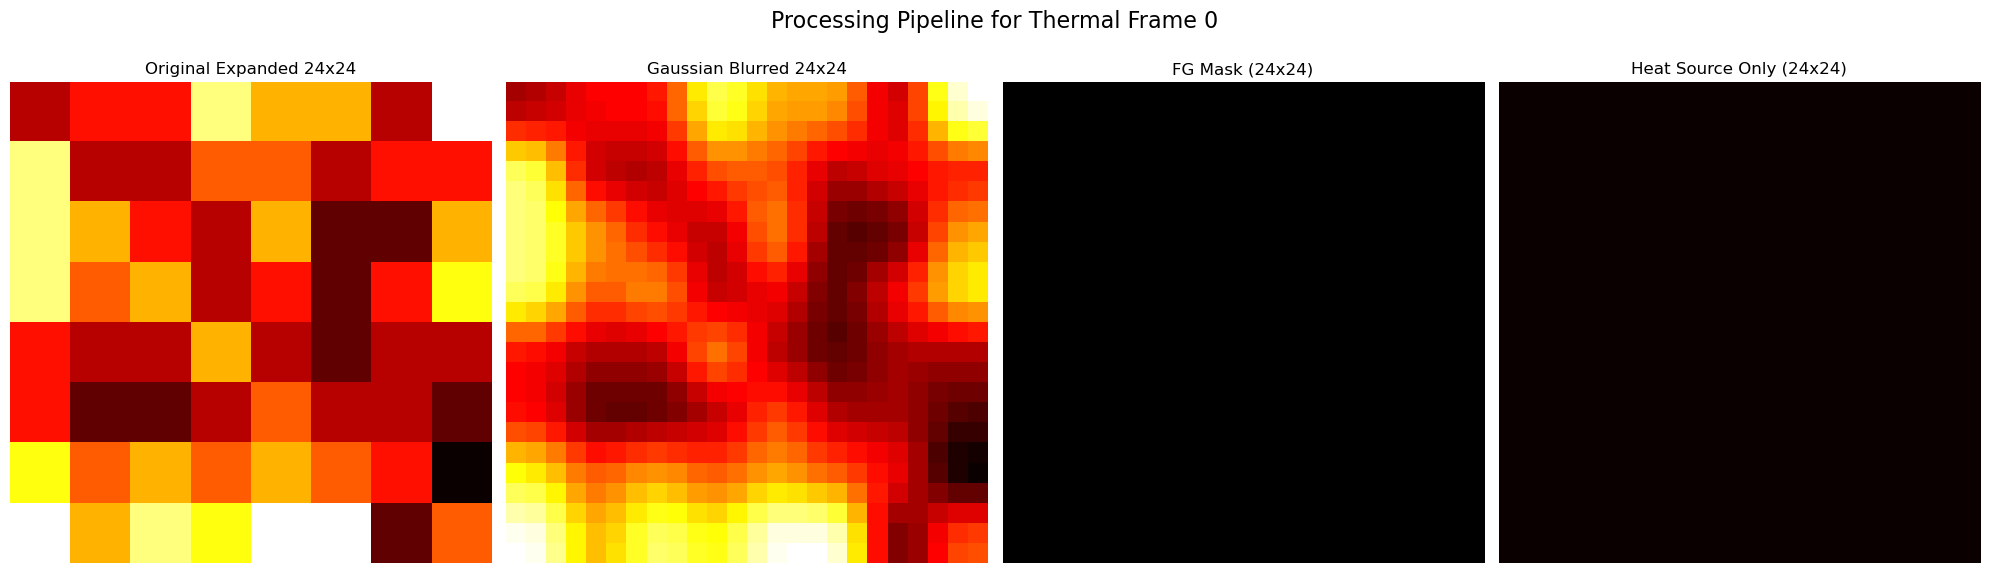

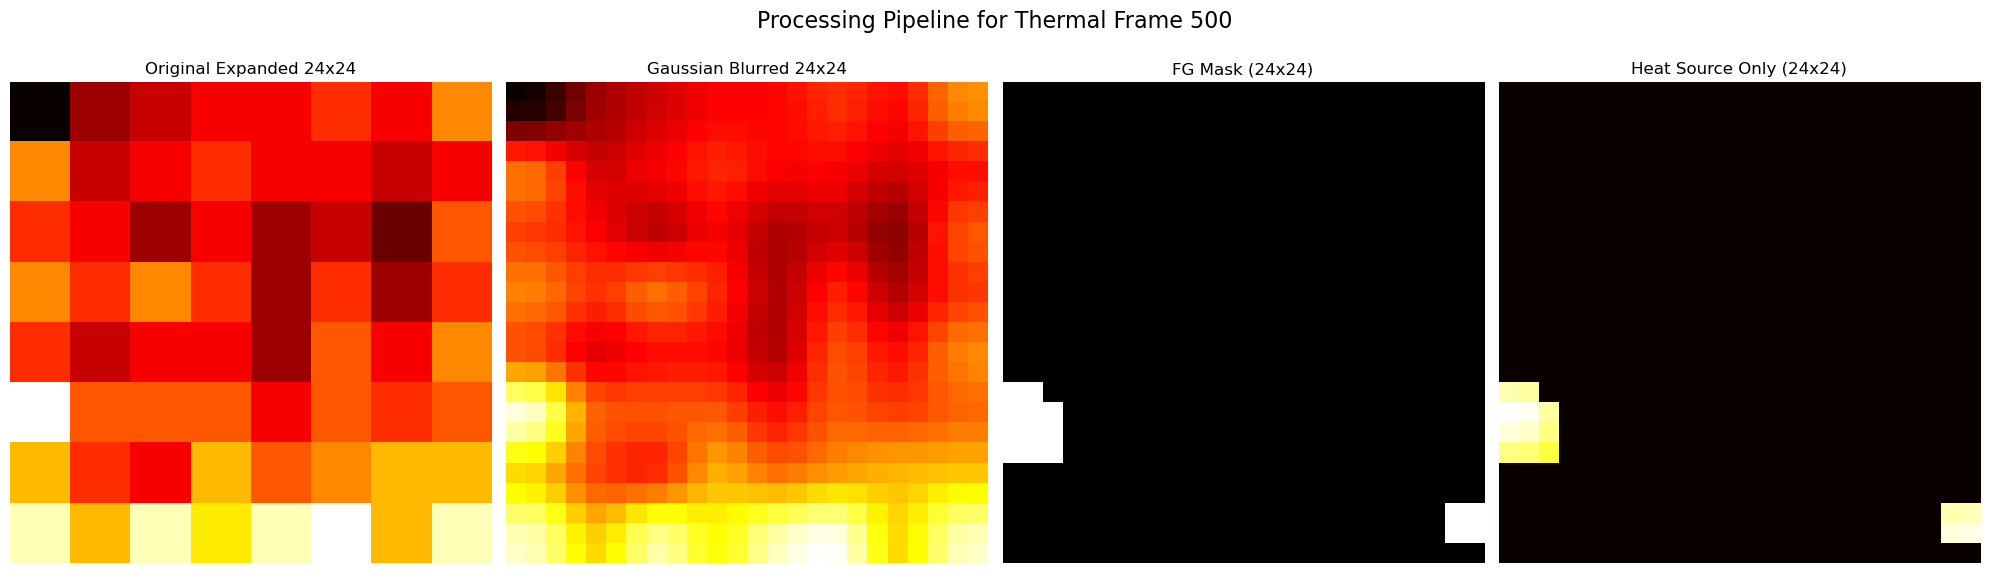

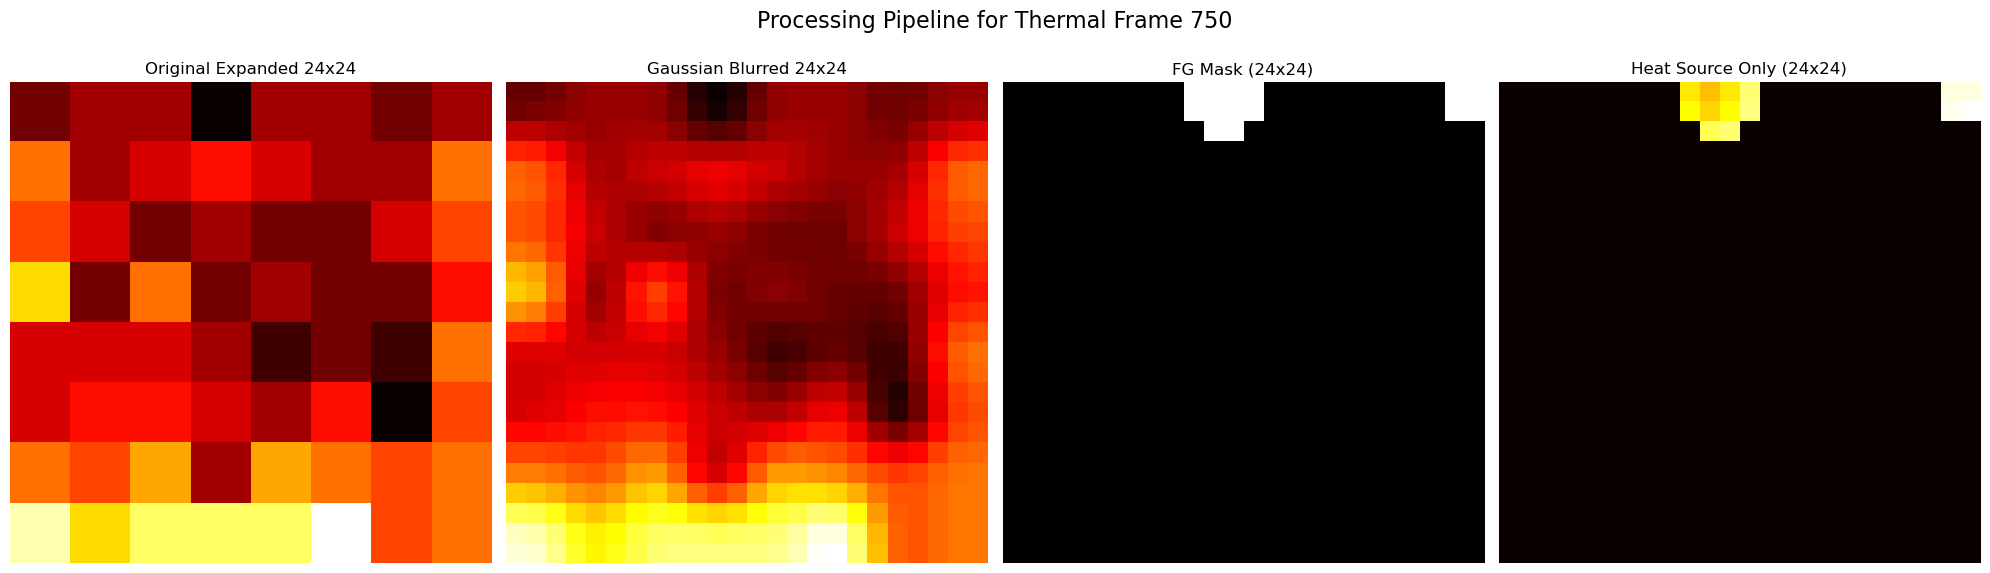

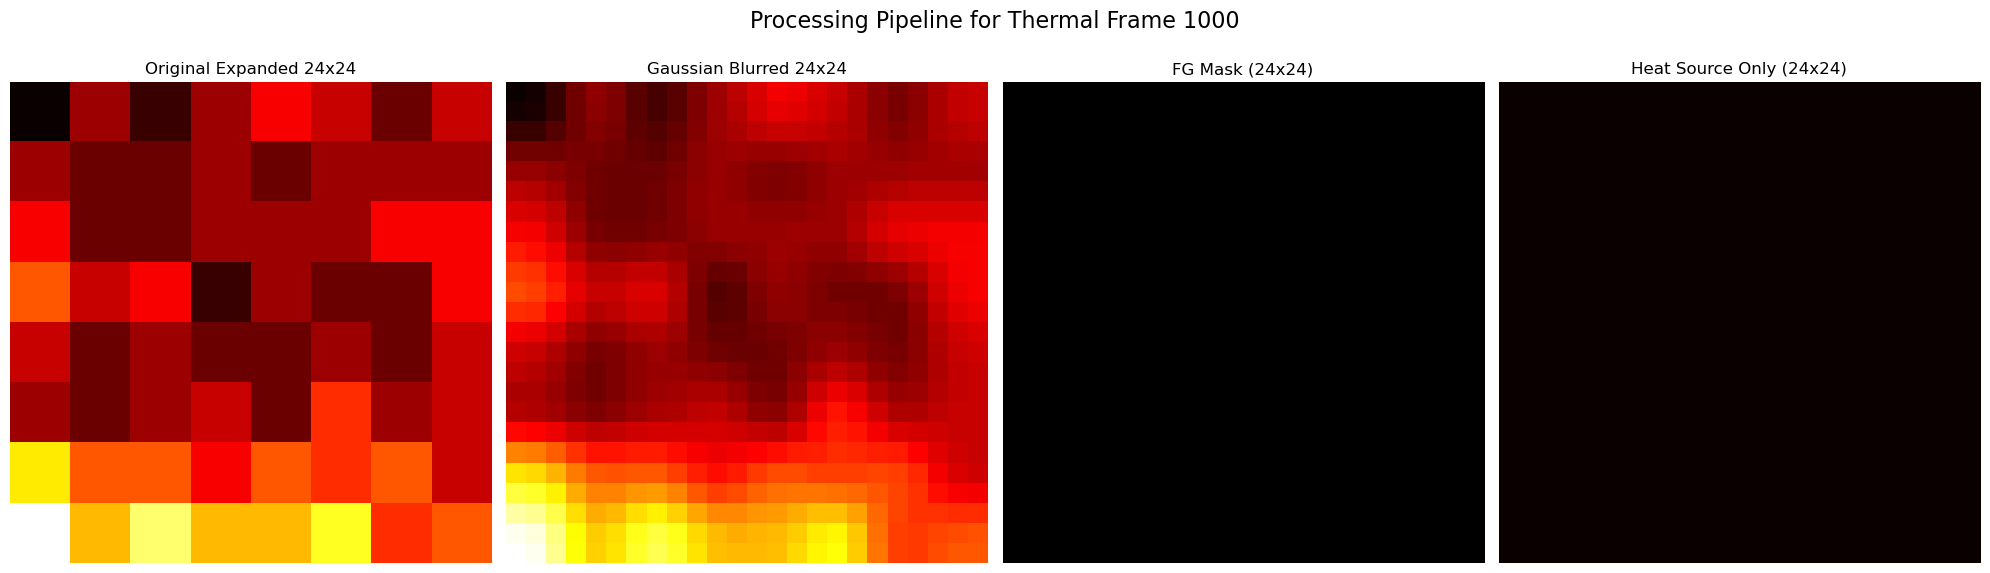

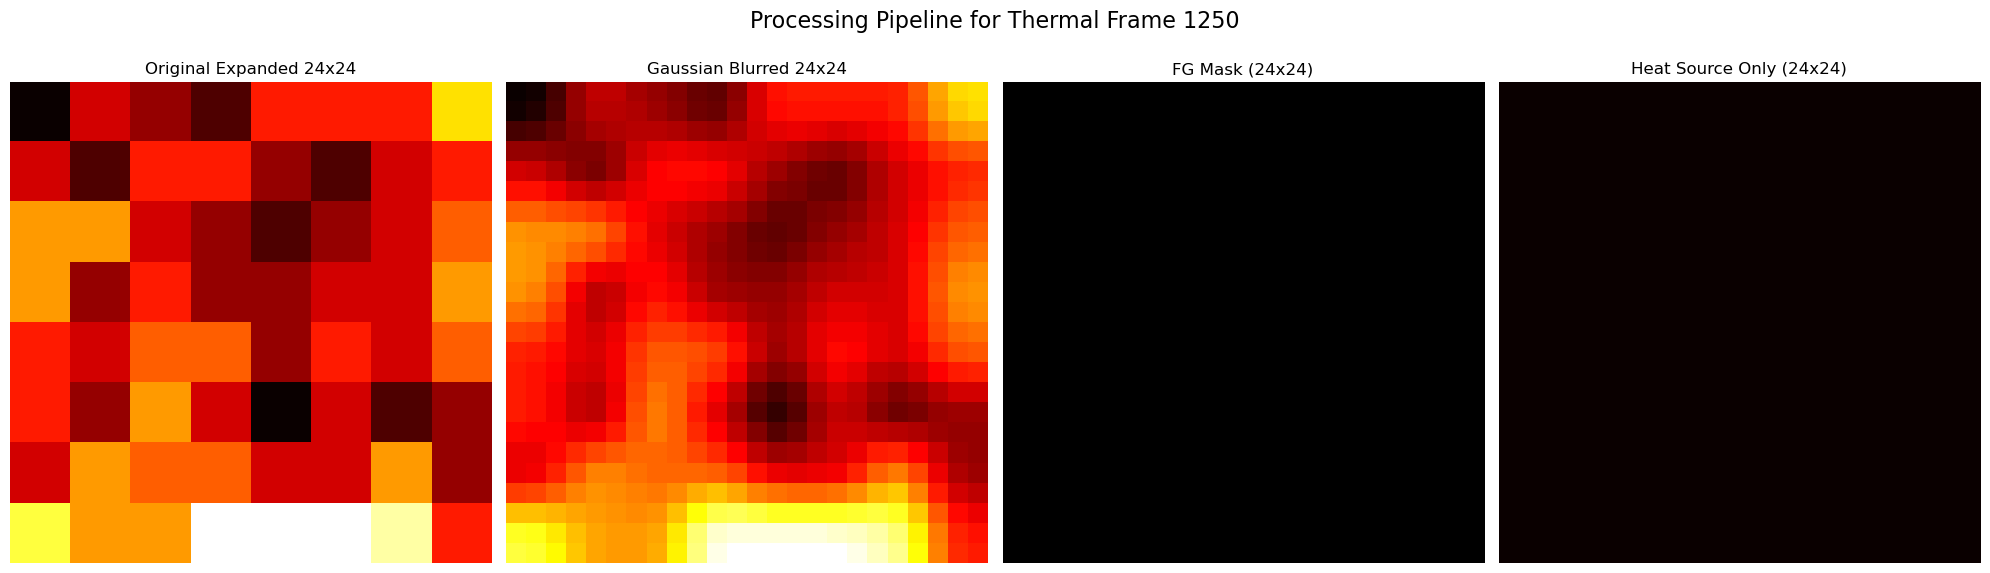

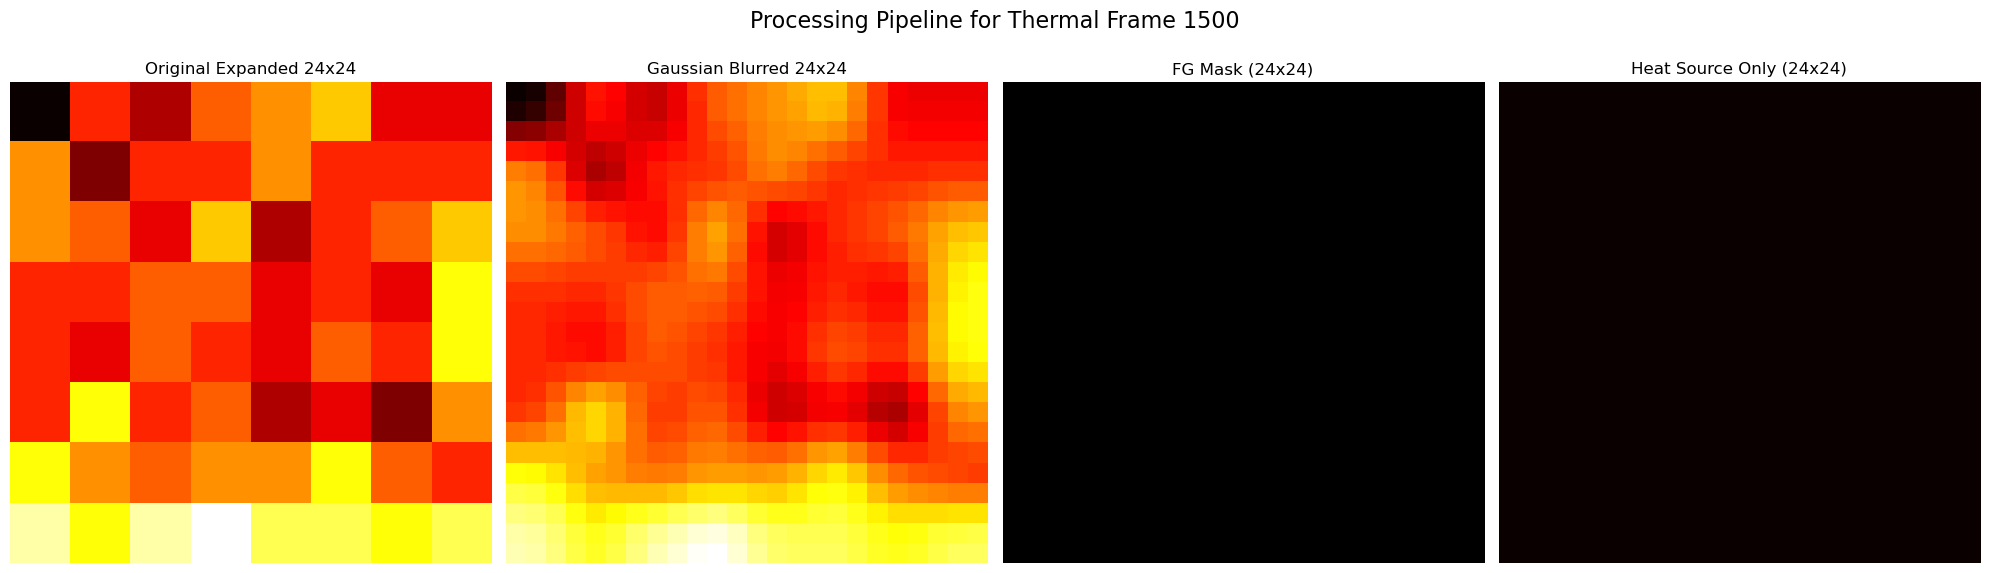

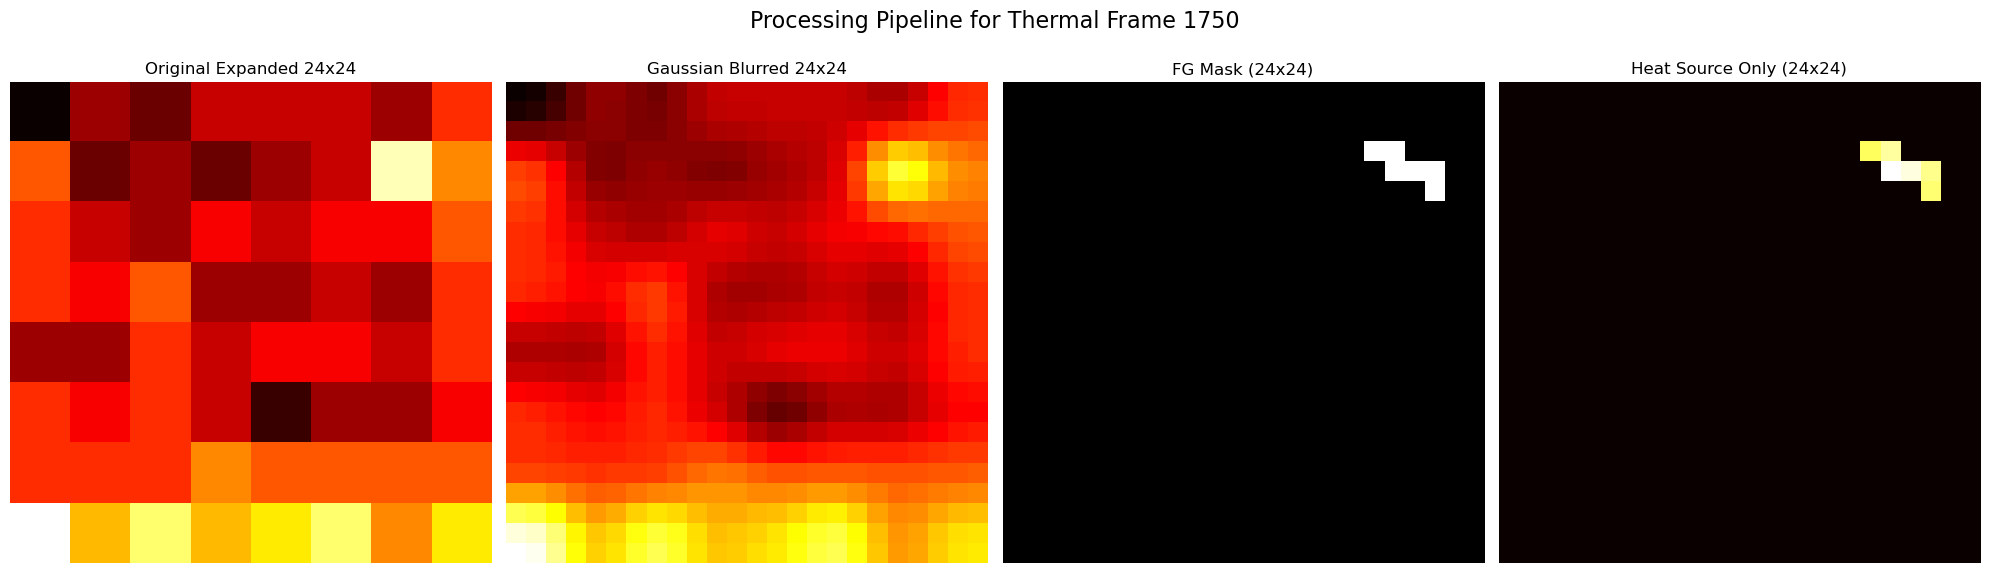


--- 마스크 후처리 결과 (열원 포함 프레임 100) ---


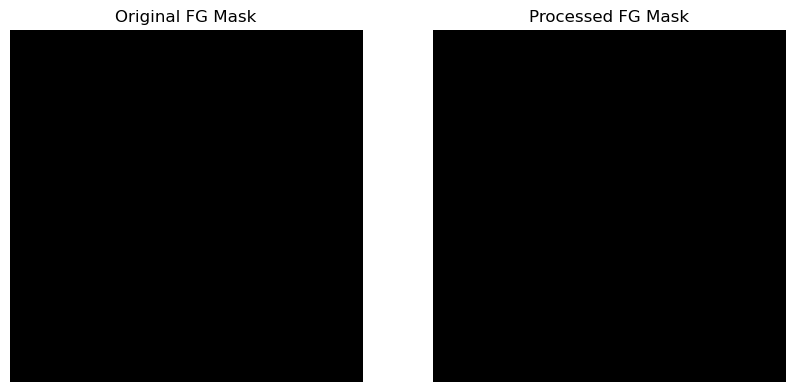

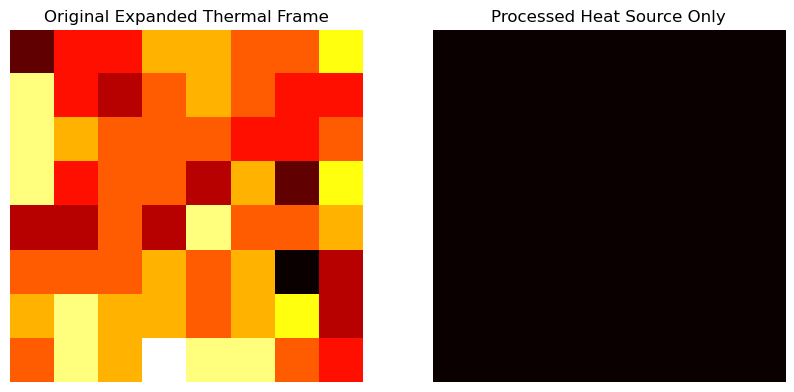

In [14]:

# --- 온도 데이터를 0-255 범위로 스케일링하는 함수 ---
def scale_temperature_to_uint8(temp_data, min_val, max_val):
    scaled_data = (temp_data - min_val) / (max_val - min_val) * 255
    scaled_data = np.clip(scaled_data, 0, 255)
    return scaled_data.astype(np.uint8)

# 전체 온도 데이터의 예상 최소/최대값 계산 (스케일링을 위해 필요)
global_min_temp = min(frames_none.min().min(), frames_hu.min().min())
global_max_temp = max(frames_none.max().max(), frames_hu.max().max())
print(f"온도 데이터 전체 범위: {global_min_temp:.2f}°C ~ {global_max_temp:.2f}°C")
print("-" * 30)

# --- 1. 데이터프레임 할당 ---
frames_background = frames_none
frames_with_object = frames_hu

print(f"배경 프레임 수: {len(frames_background)}")
print(f"열원 포함 프레임 수: {len(frames_with_object)}")
print("-" * 30)

# 2. MOG2 배경 제거기 생성
fgbg = cv2.createBackgroundSubtractorMOG2(history=len(frames_background), varThreshold=16, detectShadows=False)

# --- 가우시안 필터 파라미터 ---
gaussian_ksize = (5, 5) # 커널 크기 (양의 홀수여야 함). 픽셀화된 부분을 부드럽게.
gaussian_sigmaX = 0    # 자동 계산
original_frame_width, original_frame_height = 8, 8
expanded_frame_width, expanded_frame_height = 24, 24
# 3. 배경 프레임으로 배경 모델 초기 학습 (24x24 확장 + 가우시안 필터 적용)
print("--- 배경 프레임으로 배경 모델 학습 시작 ---")
for i in range(len(frames_background.index)):
    temp_frame_2d_original = frames_background.iloc[i,:].values.reshape((original_frame_height, original_frame_width))
    scaled_frame_original = scale_temperature_to_uint8(temp_frame_2d_original, global_min_temp, global_max_temp)
    
    # 24x24로 확대 (INTER_NEAREST는 픽셀 복제)
    expanded_frame = cv2.resize(scaled_frame_original, 
                                (expanded_frame_width, expanded_frame_height), 
                                interpolation=cv2.INTER_NEAREST)
    
    # 가우시안 필터 적용
    blurred_expanded_frame = cv2.GaussianBlur(expanded_frame, gaussian_ksize, gaussian_sigmaX)

    # 필터링된 24x24 프레임을 MOG2에 입력하여 학습
    fgmask_dummy = fgbg.apply(blurred_expanded_frame) 
    
    if (i + 1) % 500 == 0:
        print(f"  {i + 1}/{len(frames_background)} 프레임 학습 완료...")
print("--- 배경 모델 학습 완료 ---")
print("-" * 30)

# 4. 객체가 있는 프레임을 넣어 전경 감지 및 추출 (24x24 확장 + 가우시안 필터 적용)
original_expanded_frames_results = [] # 24x24로 확대만 된 스케일링 원본 프레임
blurred_expanded_frames_results = [] # 24x24로 확대 및 가우시안 필터 적용된 프레임
fg_masks_results = [] # 24x24 크기 마스크
fg_only_frames_results = [] # 24x24 크기 전경

print("--- 열원 포함 프레임 처리 시작 ---")
for i in range(len(frames_with_object.index)):
    temp_frame_2d_original = frames_with_object.iloc[i,:].values.reshape((original_frame_height, original_frame_width))
    scaled_frame_original = scale_temperature_to_uint8(temp_frame_2d_original, global_min_temp, global_max_temp)
    
    # 24x24로 확대
    expanded_frame = cv2.resize(scaled_frame_original, 
                                (expanded_frame_width, expanded_frame_height), 
                                interpolation=cv2.INTER_NEAREST)
    
    # 가우시안 필터 적용
    blurred_expanded_frame = cv2.GaussianBlur(expanded_frame, gaussian_ksize, gaussian_sigmaX)

    # 필터링된 24x24 프레임을 MOG2에 입력하여 전경 감지
    fgmask = fgbg.apply(blurred_expanded_frame) 
    
    # 전경 마스크를 사용하여 필터링된 프레임에서 열원만 추출
    fg_only = cv2.bitwise_and(blurred_expanded_frame, blurred_expanded_frame, mask=fgmask)

    original_expanded_frames_results.append(expanded_frame) 
    blurred_expanded_frames_results.append(blurred_expanded_frame) 
    fg_masks_results.append(fgmask)
    fg_only_frames_results.append(fg_only)

    if (i + 1) % 200 == 0:
        print(f"  {i + 1}/{len(frames_with_object)} 프레임 처리 완료...")
print("--- 열원 포함 프레임 처리 완료 ---")
print("-" * 30)


# 5. 결과 시각화
# 이전 display_images_temp는 사용하지 않고, display_full_pipeline을 주로 사용합니다.
def display_full_pipeline(original_expanded_img, blurred_expanded_img, fg_mask, fg_only_img, idx):
    fig, axes = plt.subplots(1, 4, figsize=(20, 6)) # 4개 서브플롯
    fig.suptitle(f'Processing Pipeline for Thermal Frame {idx}', fontsize=16)
    
    axes[0].imshow(original_expanded_img, cmap='hot')
    axes[0].set_title(f'Original Expanded {expanded_frame_width}x{expanded_frame_height}')
    axes[0].axis('off')

    axes[1].imshow(blurred_expanded_img, cmap='hot')
    axes[1].set_title(f'Gaussian Blurred {expanded_frame_width}x{expanded_frame_height}')
    axes[1].axis('off')

    axes[2].imshow(fg_mask, cmap='gray')
    axes[2].set_title(f'FG Mask ({expanded_frame_width}x{expanded_frame_height})')
    axes[2].axis('off')

    axes[3].imshow(fg_only_img, cmap='hot')
    axes[3].set_title(f'Heat Source Only ({expanded_frame_width}x{expanded_frame_height})')
    axes[3].axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # 타이틀 공간 확보
    plt.show()


# 시각화할 프레임 인덱스 선택 (요청하신 대로 확장)
display_idx = [
    0,                                      
    min(500, len(frames_with_object) - 1),  
    min(750, len(frames_with_object) - 1),  
    min(1000, len(frames_with_object) - 1), 
    min(1250, len(frames_with_object) - 1), 
    min(1500, len(frames_with_object) - 1), 
    min(1750, len(frames_with_object) - 1), 
]

# 각 인덱스에 대해 파이프라인 시각화
for idx in display_idx:
    display_full_pipeline(
        original_expanded_frames_results[idx],
        blurred_expanded_frames_results[idx],
        fg_masks_results[idx],
        fg_only_frames_results[idx],
        idx
    )

# 6. 마스크 후처리 (선택 사항)
post_process_idx = min(100, len(fg_masks_results) - 1) 
fgmask_example = fg_masks_results[post_process_idx]
# 후처리 시 원본으로 사용할 프레임은 이제 original_expanded_frames_results에서 가져옵니다.
original_expanded_frame_for_post = original_expanded_frames_results[post_process_idx] 

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

dilated_mask = cv2.dilate(fgmask_example, kernel, iterations=1)
eroded_mask = cv2.erode(dilated_mask, kernel, iterations=1)

# 후처리된 마스크를 필터링된 24x24 프레임에 적용하여 전경 추출
# 만약 마스크를 원본 스케일링된 24x24 프레임에 적용하고 싶다면 original_expanded_frame_for_post를 사용
fg_only_processed = cv2.bitwise_and(blurred_expanded_frames_results[post_process_idx], blurred_expanded_frames_results[post_process_idx], mask=eroded_mask)

print(f"\n--- 마스크 후처리 결과 (열원 포함 프레임 {post_process_idx}) ---")
# display_images_temp 함수는 2개의 이미지 비교용이므로, 여기서는 새로 정의한 display_full_pipeline과 유사하게 2개의 이미지 시각화
# 마스크 비교
display_images_temp(fgmask_example, 'Original FG Mask', eroded_mask, 'Processed FG Mask', cmap_val='gray')
# 최종 결과 비교
display_images_temp(original_expanded_frame_for_post, 'Original Expanded Thermal Frame', fg_only_processed, 'Processed Heat Source Only', cmap_val='hot')

--- 배경 모델 학습 시작 ---
  500/4003 프레임 학습 완료...
  1000/4003 프레임 학습 완료...
  1500/4003 프레임 학습 완료...
  2000/4003 프레임 학습 완료...
  2500/4003 프레임 학습 완료...
  3000/4003 프레임 학습 완료...
  3500/4003 프레임 학습 완료...
  4000/4003 프레임 학습 완료...
--- 배경 모델 학습 완료 ---
------------------------------
--- 테스트 데이터 처리 및 시각화 시작 ---

처리 중인 테스트 프레임: 0


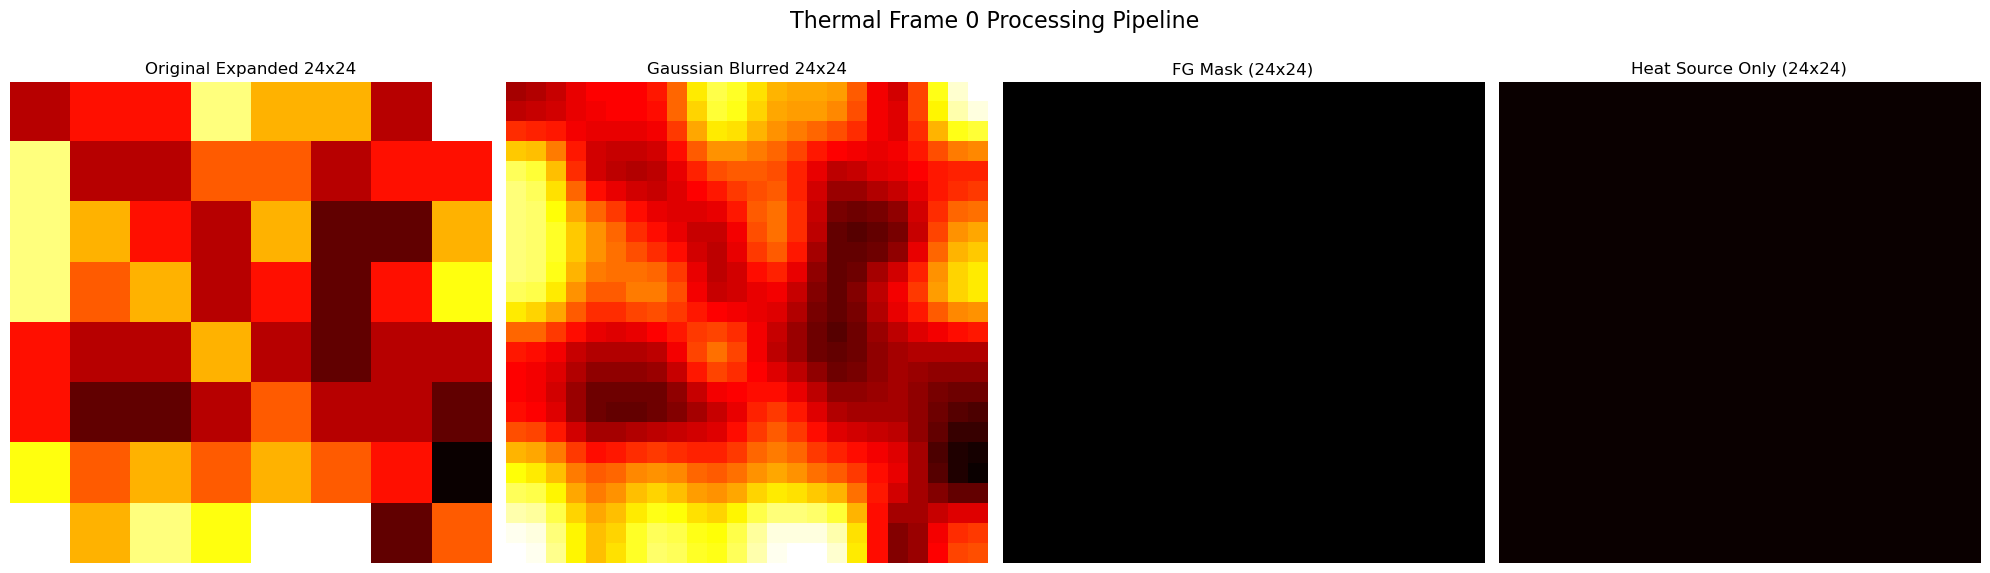


처리 중인 테스트 프레임: 50


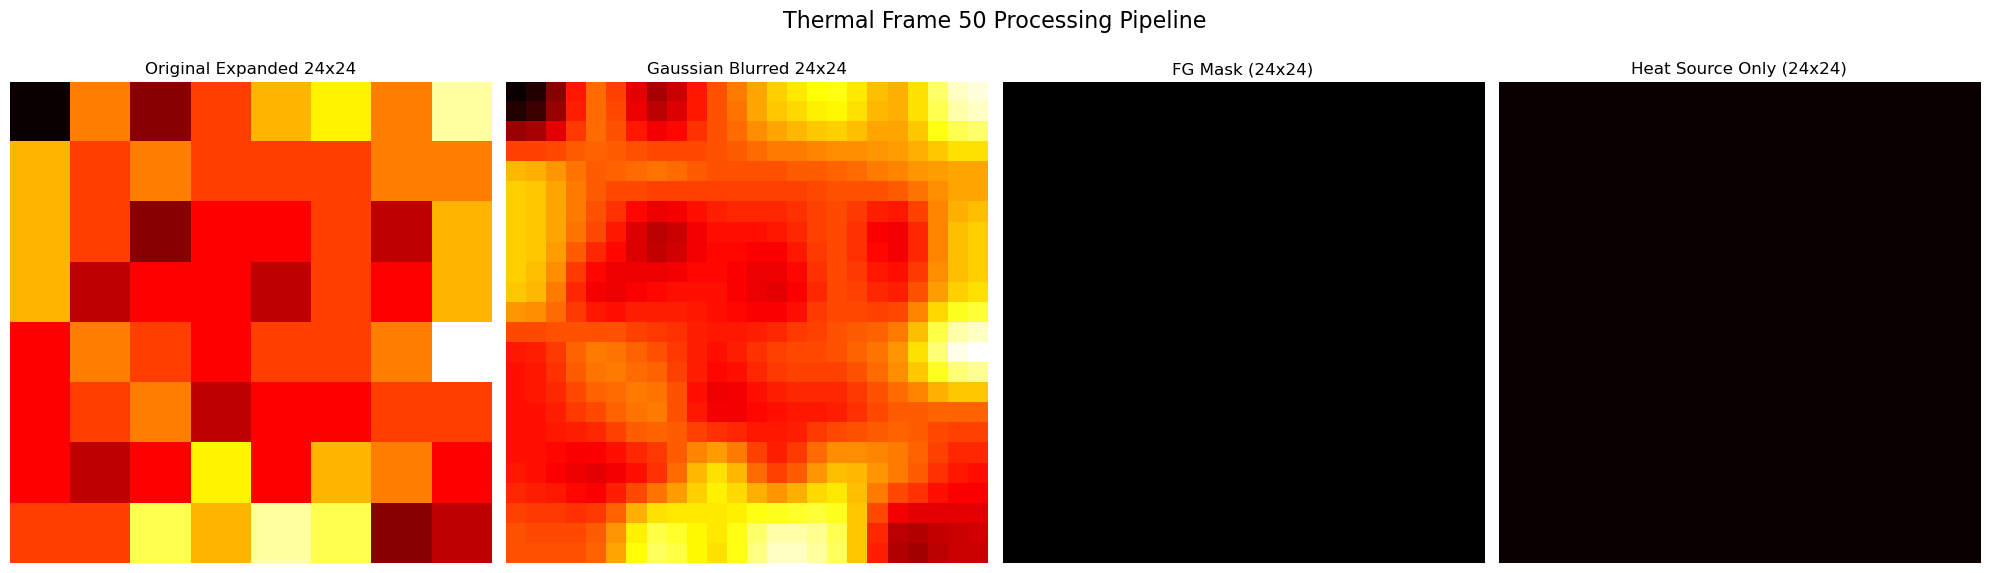


처리 중인 테스트 프레임: 100


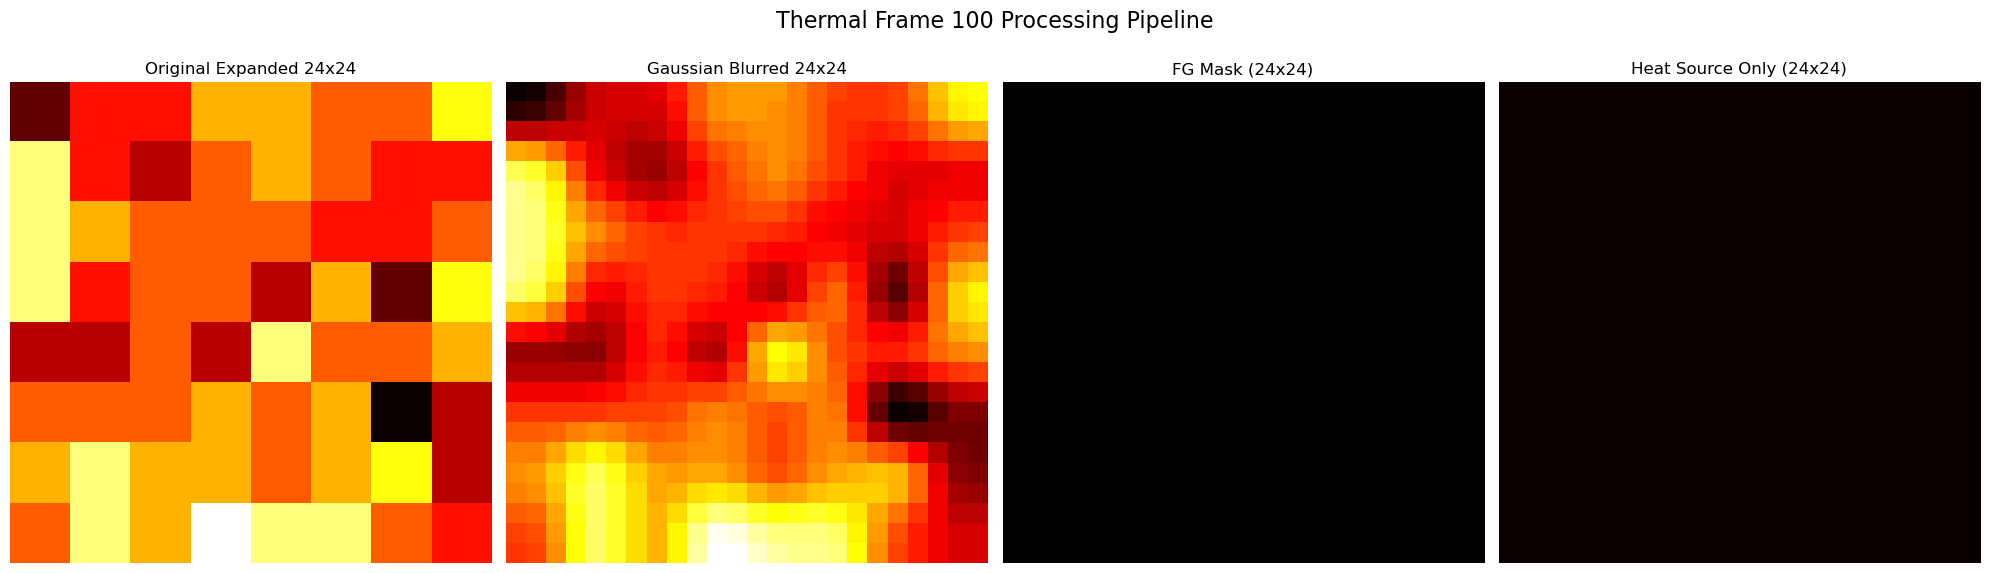


처리 중인 테스트 프레임: 500


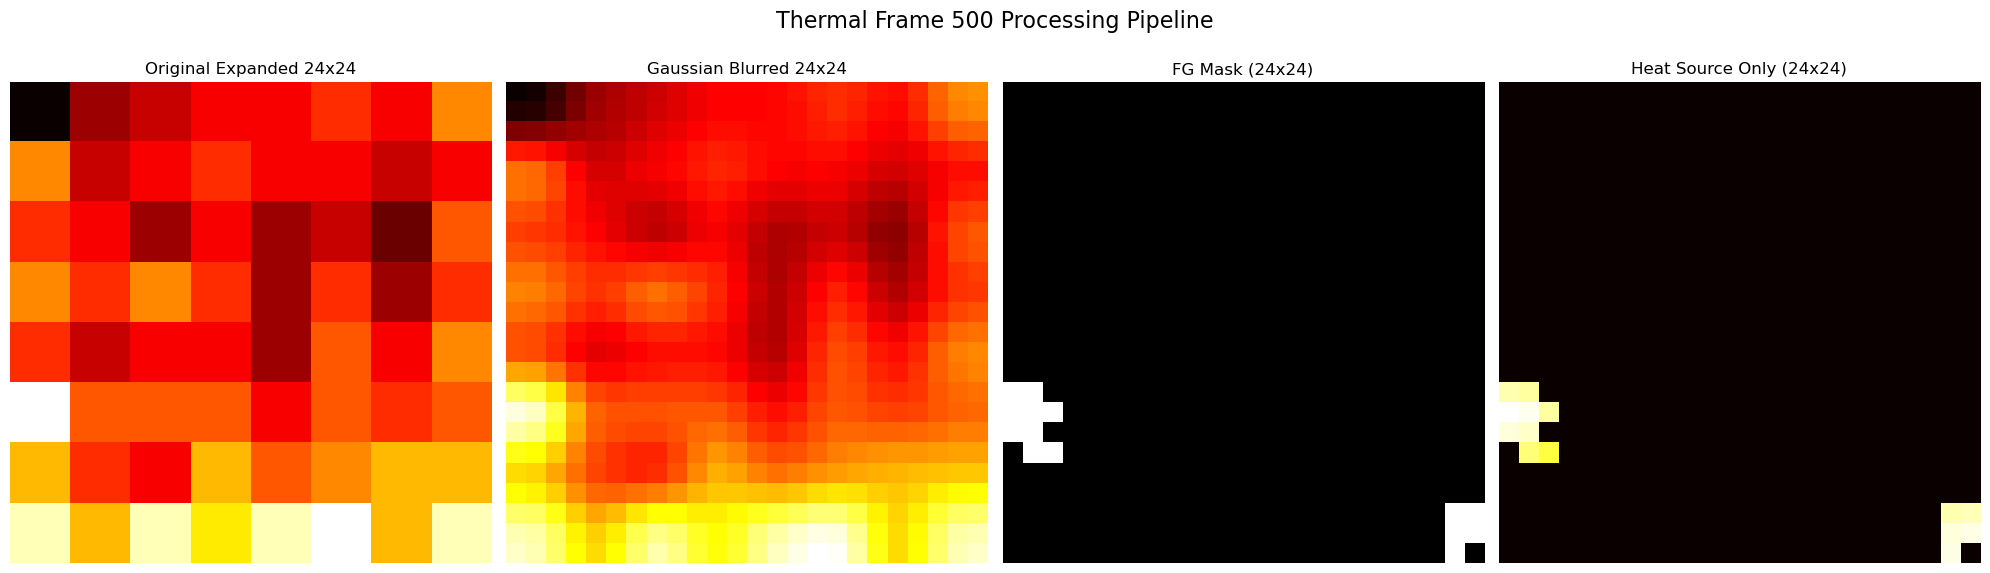


처리 중인 테스트 프레임: 1000


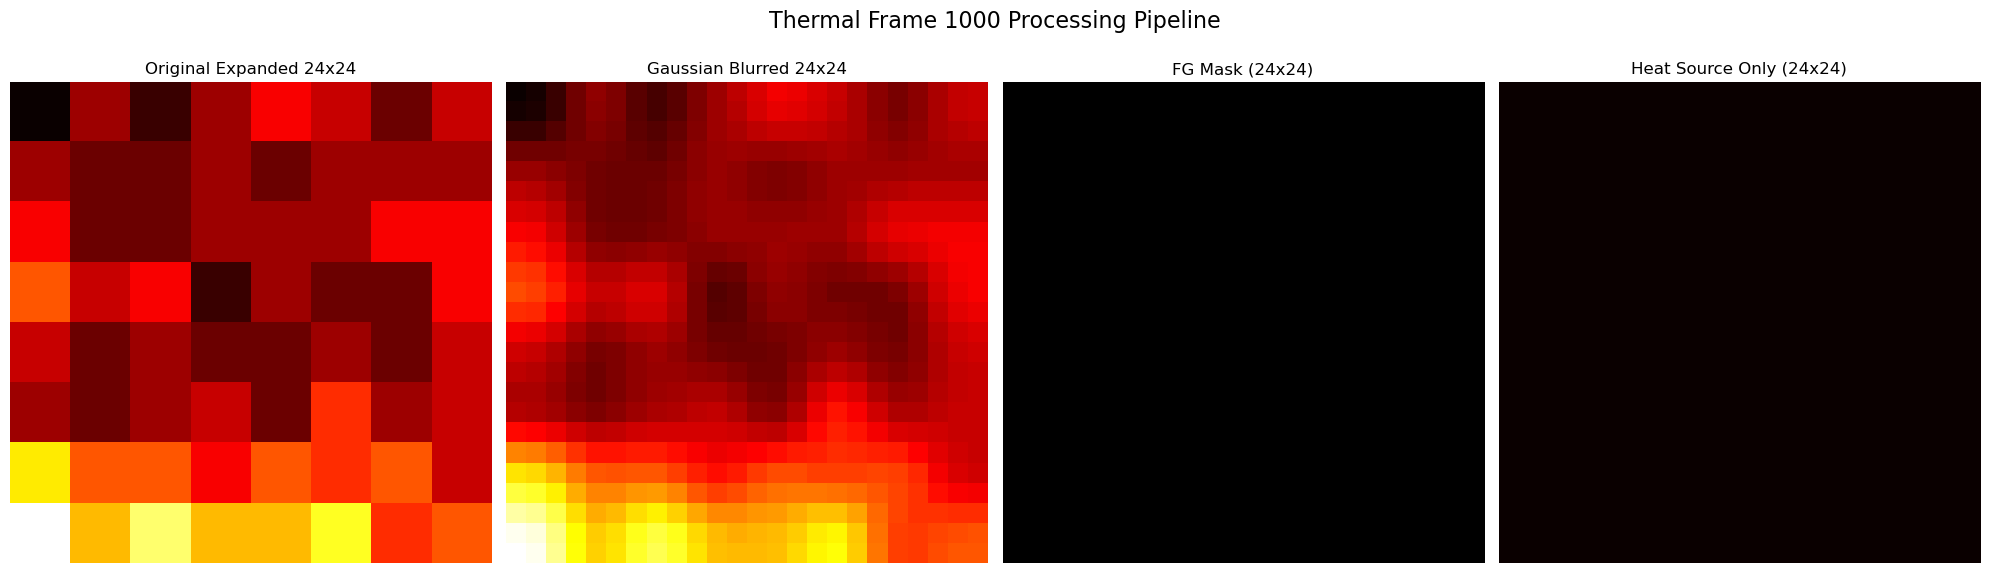


처리 중인 테스트 프레임: 1500


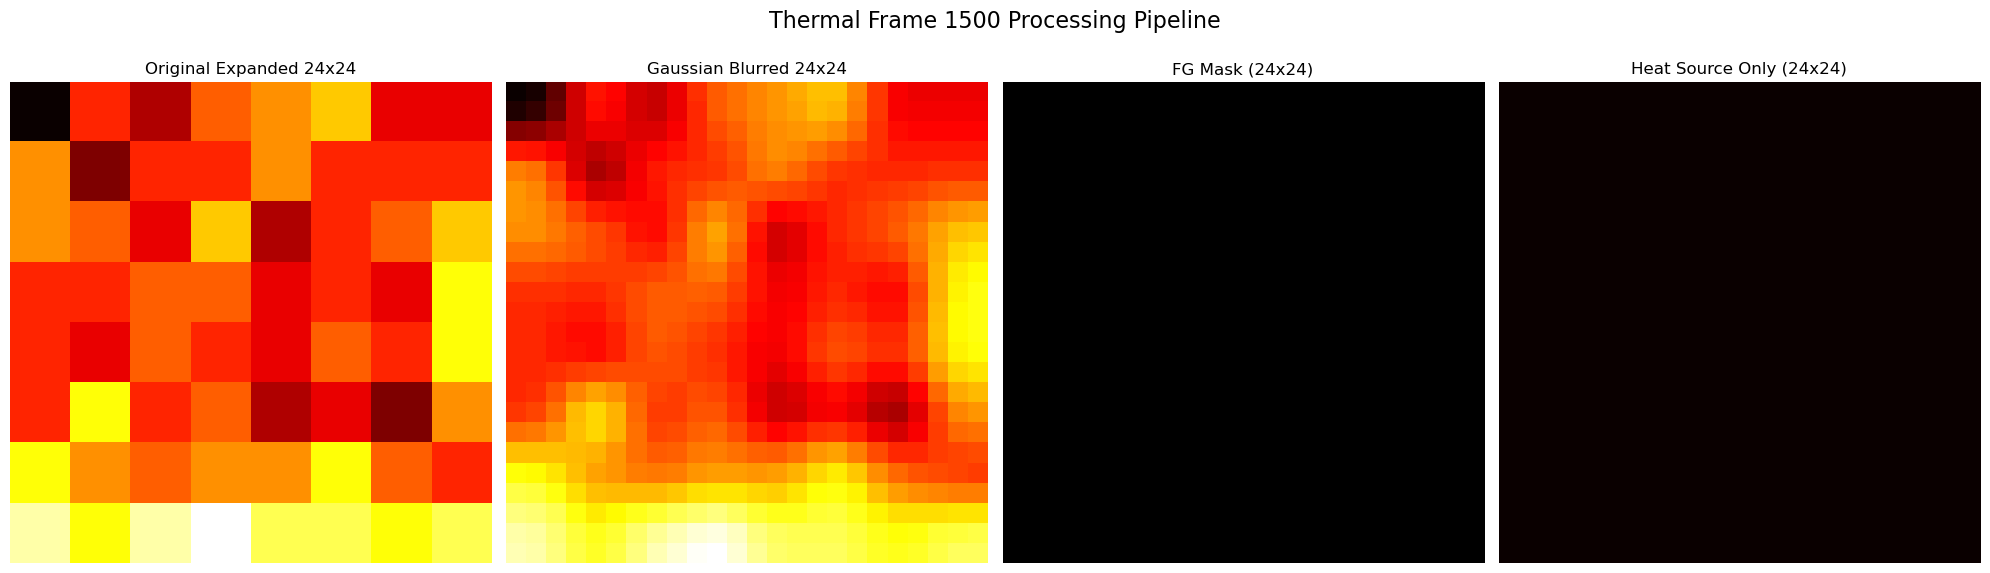

--- 테스트 데이터 처리 및 시각화 완료 ---


In [15]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 헬퍼 함수 정의 (이전 코드에서 가져옴) ---

# 온도 데이터를 0-255 범위로 스케일링하는 함수
def scale_temperature_to_uint8(temp_data, min_val, max_val):
    scaled_data = (temp_data - min_val) / (max_val - min_val) * 255
    scaled_data = np.clip(scaled_data, 0, 255)
    return scaled_data.astype(np.uint8)

# 결과 시각화 헬퍼 함수
def display_full_pipeline(original_expanded_img, blurred_expanded_img, fg_mask, fg_only_img, idx):
    fig, axes = plt.subplots(1, 4, figsize=(20, 6))
    fig.suptitle(f'Thermal Frame {idx} Processing Pipeline', fontsize=16) # 타이틀 변경
    
    axes[0].imshow(original_expanded_img, cmap='hot')
    axes[0].set_title(f'Original Expanded {expanded_frame_width}x{expanded_frame_height}')
    axes[0].axis('off')

    axes[1].imshow(blurred_expanded_img, cmap='hot')
    axes[1].set_title(f'Gaussian Blurred {expanded_frame_width}x{expanded_frame_height}')
    axes[1].axis('off')

    axes[2].imshow(fg_mask, cmap='gray')
    axes[2].set_title(f'FG Mask ({expanded_frame_width}x{expanded_frame_height})')
    axes[2].axis('off')

    axes[3].imshow(fg_only_img, cmap='hot')
    axes[3].set_title(f'Heat Source Only ({expanded_frame_width}x{expanded_frame_height})')
    axes[3].axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- 새로운 함수: 테스트 데이터 처리 및 시각화 ---
def process_and_visualize_test_frame(test_frame_data, fgbg_model, min_temp, max_temp, 
                                     original_height, original_width, 
                                     expanded_height, expanded_width,
                                     gaussian_ksize=(5, 5), gaussian_sigmaX=0,
                                     frame_idx=None):
    """
    하나의 테스트 프레임을 입력받아 전체 배경 제거 파이프라인을 적용하고 결과를 시각화합니다.
    
    Args:
        test_frame_data (np.array 또는 pd.Series): 1차원 형태의 테스트 프레임 픽셀 데이터 (8x8 = 64개).
        fgbg_model (cv2.BackgroundSubtractorMOG2): 이미 학습된 배경 제거 모델.
        min_temp (float): 전체 데이터의 최소 예상 온도 (스케일링용).
        max_temp (float): 전체 데이터의 최대 예상 온도 (스케일링용).
        original_height (int): 원본 프레임의 높이 (8).
        original_width (int): 원본 프레임의 너비 (8).
        expanded_height (int): 확장할 프레임의 높이 (24).
        expanded_width (int): 확장할 프레임의 너비 (24).
        gaussian_ksize (tuple): 가우시안 필터 커널 크기.
        gaussian_sigmaX (float): 가우시안 필터 표준 편차.
        frame_idx (int, optional): 현재 프레임의 인덱스 (시각화 타이틀에 사용). 기본값은 None.
    """
    
    # 1. 1차원 데이터를 원본 2D 배열로 재구성
    temp_frame_2d_original = test_frame_data.reshape((original_height, original_width))
    
    # 2. 온도 데이터를 0-255 범위로 스케일링
    scaled_frame_original = scale_temperature_to_uint8(temp_frame_2d_original, min_temp, max_temp)
    
    # 3. 24x24로 확대 (INTER_NEAREST는 픽셀 복제)
    expanded_frame = cv2.resize(scaled_frame_original, 
                                (expanded_height, expanded_width), 
                                interpolation=cv2.INTER_NEAREST)
    
    # 4. 가우시안 필터 적용
    blurred_expanded_frame = cv2.GaussianBlur(expanded_frame, gaussian_ksize, gaussian_sigmaX)

    # 5. MOG2 모델에 적용하여 전경 마스크 얻기 (learningRate=0으로 설정하여 배경 모델 업데이트 방지)
    # 테스트 단계에서는 학습된 모델을 고정하고 싶을 수 있습니다.
    # 만약 테스트 데이터에서도 배경 모델을 업데이트하려면 learningRate= -1 (기본값) 또는 양수 값을 사용하세요.
    fgmask = fgbg_model.apply(blurred_expanded_frame, learningRate=0) 
    
    # 6. 전경 마스크를 사용하여 필터링된 프레임에서 열원만 추출
    fg_only = cv2.bitwise_and(blurred_expanded_frame, blurred_expanded_frame, mask=fgmask)

    # 7. 결과 시각화
    display_full_pipeline(
        expanded_frame, # 원본 스케일링 + 확대
        blurred_expanded_frame, # 가우시안 필터 적용
        fgmask, # 전경 마스크
        fg_only, # 열원만 추출된 결과
        frame_idx if frame_idx is not None else "Test"
    )
    
    # 예측 결과 반환 (옵션)
    # 여기서는 추출된 열원 이미지와 마스크를 반환하도록 설정
    return fg_only, fgmask

# --- 전체 파이프라인 실행 예시 (위 함수를 사용하여 테스트 데이터 처리) ---

# 가상 데이터 생성 (실제 데이터를 로드하는 코드로 대체 필요)
np.random.seed(42)

original_frame_height, original_frame_width = 8, 8
expanded_frame_height, expanded_frame_width = 24, 24

heat_source_size = 3
heat_source_temp_boost = 15.0

global_min_temp = min(frames_none.min().min(), frames_hu.min().min())
global_max_temp = max(frames_none.max().max(), frames_hu.max().max())

# --- 1. 배경 모델 학습 ---
print("--- 배경 모델 학습 시작 ---")
fgbg = cv2.createBackgroundSubtractorMOG2(history=len(frames_none), varThreshold=16, detectShadows=False)

gaussian_ksize = (5, 5) 
gaussian_sigmaX = 0    

for i in range(len(frames_none.index)):
    temp_frame_2d_original = frames_none.iloc[i,:].values.reshape((original_frame_height, original_frame_width))
    scaled_frame_original = scale_temperature_to_uint8(temp_frame_2d_original, global_min_temp, global_max_temp)
    
    expanded_frame = cv2.resize(scaled_frame_original, 
                                (expanded_frame_width, expanded_frame_height), 
                                interpolation=cv2.INTER_NEAREST)
    
    blurred_expanded_frame = cv2.GaussianBlur(expanded_frame, gaussian_ksize, gaussian_sigmaX)
    fgbg.apply(blurred_expanded_frame) 
    
    if (i + 1) % 500 == 0:
        print(f"  {i + 1}/{len(frames_none)} 프레임 학습 완료...")
print("--- 배경 모델 학습 완료 ---")
print("-" * 30)

# --- 2. 테스트 데이터로 함수 호출 및 결과 확인 ---
print("--- 테스트 데이터 처리 및 시각화 시작 ---")

# frames_hu에서 몇 가지 테스트 프레임을 선택하여 함수 호출
test_frame_indices = [0, 50, 100, 500, min(1000, len(frames_hu) - 1), min(1500, len(frames_hu) - 1)]

for i, idx in enumerate(test_frame_indices):
    print(f"\n처리 중인 테스트 프레임: {idx}")
    test_frame = frames_hu.iloc[idx].values # pandas Series를 numpy array로 변환
    
    # 함수 호출
    extracted_heat_source, prediction_mask = process_and_visualize_test_frame(
        test_frame,
        fgbg, # 학습된 fgbg 모델 전달
        global_min_temp,
        global_max_temp,
        original_frame_height,
        original_frame_width,
        expanded_frame_height,
        expanded_frame_width,
        gaussian_ksize,
        gaussian_sigmaX,
        frame_idx=idx # 프레임 인덱스 전달
    )
    
    # 반환된 예측 결과(마스크와 열원 이미지)를 필요에 따라 추가 처리/저장할 수 있습니다.
    # print(f"프레임 {idx}의 추출된 열원 형태: {extracted_heat_source.shape}")
    # print(f"프레임 {idx}의 예측 마스크 형태: {prediction_mask.shape}")

print("--- 테스트 데이터 처리 및 시각화 완료 ---")

In [16]:
test_frame_data = [24.75,24.5,24.5,24.5,24.75,24.0,23.25,23.75,25.25,24.0,24.0,24.25,24.0,24.0,24.25,23.75,26.75,25.25,23.5,24.25,24.0,24.25,23.75,24.25,26.0,24.5,24.5,23.75,23.5,23.75,23.75,24.25,24.25,23.5,24.0,24.25,24.0,24.25,23.5,24.25,24.5,24.5,24.25,24.0,24.25,23.75,23.75,23.75,24.25,24.0,24.25,24.25,24.5,24.25,24.25,24.25,25.25,24.5,25.25,24.5,25.25,25.25,24.25,24.75]
process_and_visualize_test_frame(test_frame_data, fgbg_model)

NameError: name 'fgbg_model' is not defined

전체 데이터의 예상 온도 범위: 24.00°C ~ 26.00°C
------------------------------
--- 열원 포함 프레임 (frames_hu) 예시 ---


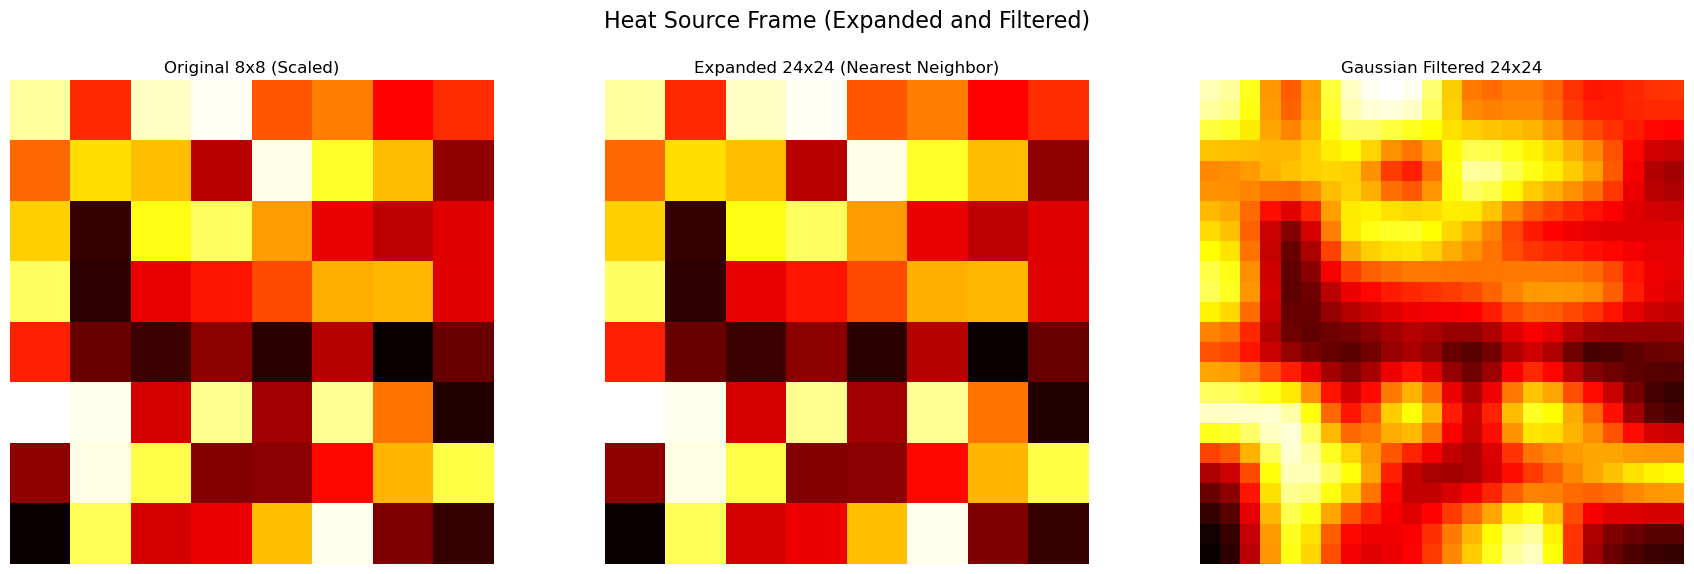

--- 배경 프레임 (frames_none) 예시 ---


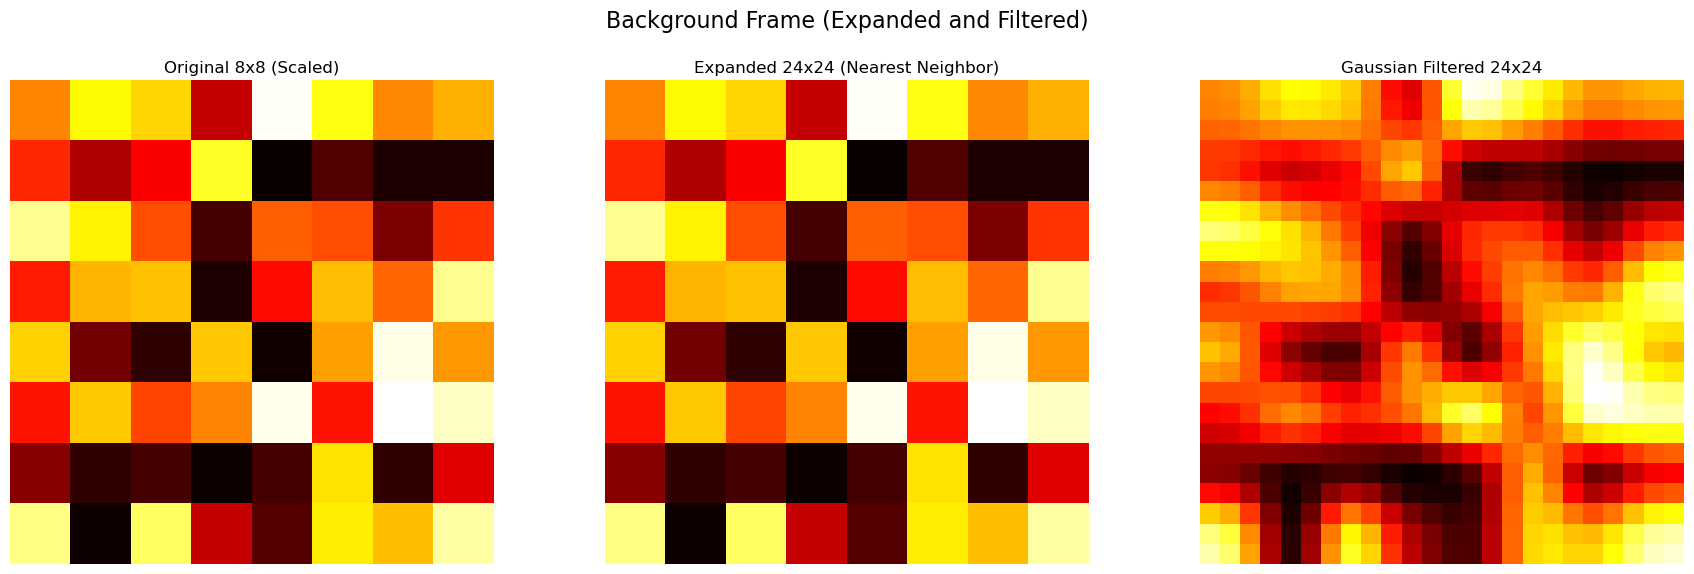

In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 헬퍼 함수 정의 ---

# 온도 데이터를 0-255 범위로 스케일링하는 함수 (이전 코드와 동일)
def scale_temperature_to_uint8(temp_data, min_val, max_val):
    scaled_data = (temp_data - min_val) / (max_val - min_val) * 255
    scaled_data = np.clip(scaled_data, 0, 255)
    return scaled_data.astype(np.uint8)

# --- 24x24로 확장하고 가우시안 필터를 적용하여 시각화하는 함수 ---
def visualize_expanded_gaussian_frame(frame_data, original_height, original_width, 
                                      expanded_height, expanded_width,
                                      min_temp, max_temp, 
                                      gaussian_ksize=(3, 3), gaussian_sigmaX=0,
                                      title="Expanded and Gaussian Filtered Thermal Frame"):
    
    # 1. 1차원 데이터를 원본 2D 배열로 재구성
    original_2d_temp = frame_data.reshape((original_height, original_width))
    
    # 2. 온도 데이터를 0-255 범위로 스케일링 (uint8 타입)
    scaled_frame = scale_temperature_to_uint8(original_2d_temp, min_temp, max_temp)
    
    # 3. 24x24 배열로 확대 (cv2.resize 사용 - INTER_NEAREST는 최근린 보간법)
    # 24x24로 확대할 때, OpenCV의 resize 함수를 사용하는 것이 일반적입니다.
    # dsize는 (width, height) 순서입니다.
    expanded_frame = cv2.resize(scaled_frame, (expanded_width, expanded_height), interpolation=cv2.INTER_NEAREST)
    
    # 4. 가우시안 필터 적용
    # expanded_frame은 이미 0-255 uint8 타입이므로 바로 필터 적용 가능
    filtered_expanded_frame = cv2.GaussianBlur(expanded_frame, gaussian_ksize, gaussian_sigmaX)
    
    # 5. 시각화
    fig, axes = plt.subplots(1, 3, figsize=(18, 6)) # 3개 서브플롯
    fig.suptitle(title, fontsize=16)

    # 원본 (확대 전)
    axes[0].imshow(scaled_frame, cmap='hot')
    axes[0].set_title(f'Original {original_width}x{original_height} (Scaled)')
    axes[0].axis('off')

    # 확대된 이미지
    axes[1].imshow(expanded_frame, cmap='hot')
    axes[1].set_title(f'Expanded {expanded_width}x{expanded_height} (Nearest Neighbor)')
    axes[1].axis('off')

    # 가우시안 필터 적용 후
    axes[2].imshow(filtered_expanded_frame, cmap='hot')
    axes[2].set_title(f'Gaussian Filtered {expanded_width}x{expanded_height}')
    axes[2].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # 타이틀 공간 확보
    plt.show()

# --- 함수 사용 예시 (이전 데이터프레임 구조 가정) ---

# 가상 데이터 생성 (실제 데이터 로드 코드 대신)
np.random.seed(42)

# frames_none (4073, 64) - 배경만 있는 데이터
data_none_temps = np.random.uniform(24.0, 26.0, size=(4073, 8*8))
frames_none = pd.DataFrame(data_none_temps)

# frames_hu (2000, 64) - 열원 포함 데이터
data_hu_temps = np.random.uniform(24.0, 26.0, size=(2000, 8*8))
frames_hu = pd.DataFrame(data_hu_temps)

# # frames_hu에 열원 시뮬레이션 추가 (이 부분은 실제 데이터 사용 시 삭제)
# frame_height, frame_width = 8, 8
# heat_source_size = 3
# heat_source_temp_boost = 15.0

# for i in range(len(frames_hu)):
#     if i % 2 == 0:
#         frame_2d_temp = frames_hu.iloc[i].values.reshape(frame_height, frame_width)
#         x_start = (i * 1) % (frame_width - heat_source_size + 1)
#         y_start = (i * 2) % (frame_height - heat_source_size + 1)
#         frame_2d_temp[y_start:y_start+heat_source_size, x_start:x_start+heat_source_size] += heat_source_temp_boost
#         frames_hu.iloc[i] = frame_2d_temp.flatten()

# 전체 온도 데이터의 예상 최소/최대값 계산 (스케일링을 위해 필요)
global_min_temp = min(frames_none.min().min(), frames_hu.min().min())
global_max_temp = max(frames_none.max().max(), frames_hu.max().max())

print(f"전체 데이터의 예상 온도 범위: {global_min_temp:.2f}°C ~ {global_max_temp:.2f}°C")
print("-" * 30)

# frames_hu의 첫 번째 프레임 (객체가 있을 수 있는 프레임)을 사용하여 함수 호출
print("--- 열원 포함 프레임 (frames_hu) 예시 ---")
visualize_expanded_gaussian_frame(
    frames_hu.iloc[10].values, # 10번째 프레임 선택
    original_height=8, original_width=8, 
    expanded_height=24, expanded_width=24,
    min_temp=global_min_temp, max_temp=global_max_temp,
    gaussian_ksize=(5, 5), gaussian_sigmaX=0, # 가우시안 커널 크기 조정 가능
    title="Heat Source Frame (Expanded and Filtered)"
)

# frames_none의 첫 번째 프레임 (배경 프레임)을 사용하여 함수 호출
print("--- 배경 프레임 (frames_none) 예시 ---")
visualize_expanded_gaussian_frame(
    frames_none.iloc[5].values, # 5번째 프레임 선택
    original_height=8, original_width=8, 
    expanded_height=24, expanded_width=24,
    min_temp=global_min_temp, max_temp=global_max_temp,
    gaussian_ksize=(5, 5), gaussian_sigmaX=0,
    title="Background Frame (Expanded and Filtered)"
)